# iDetect: Investor Mood Detection for Job Creation

## Project Overview

**Mission:** Eradicate youth unemployment through job creation

**Problem:** Timing investor/partner pitches is critical for entrepreneurial success. iDetect uses facial expression analysis to detect approachability, helping entrepreneurs optimize interaction timing to improve funding outcomes and create more job opportunities.

**Dataset:** AffectNet - Large-scale facial expression dataset
- **Approachable (Class 1):** Happy, Neutral
- **Not Approachable (Class 0):** Angry, Contempt

**Objective:** Compare traditional machine learning (SVM) with deep learning approaches to classify investor mood as approachable or not approachable.

## Table of Contents

1. **Setup & Dependencies**
2. **Google Colab Setup (Drive Mounting)**
3. **Data Loading & Preprocessing**
4. **Traditional ML: SVM Experiments (7 Experiments)**
5. **Deep Learning Experiments (7 Experiments)**
6. **Final Comparison & Best Model Selection**
7. **Conclusions & Insights**

## 1. Setup & Dependencies

### Why These Libraries?

- **NumPy & Pandas:** Essential for data manipulation and numerical operations
- **Matplotlib & Seaborn:** For comprehensive visualizations (learning curves, confusion matrices, heatmaps)
- **Scikit-learn:** Traditional ML models (SVM) and evaluation metrics
- **TensorFlow/Keras:** Deep learning models (Sequential & Functional APIs)
- **OpenCV:** Image preprocessing and feature extraction (HOG, LBP)
- **tqdm:** Progress bars for long-running operations

### Reproducibility Settings

Setting random seeds ensures reproducible results across runs, critical for comparing experiments fairly.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve)

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '0'

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully
TensorFlow version: 2.19.0
NumPy version: 2.0.2


### GPU Configuration & Optimization

**Why GPU Optimization?**

- **Mixed Precision Training:** Uses float16 instead of float32, reducing memory usage and speeding up training by 2-3x on modern GPUs
- **tf.data API:** Efficient data pipeline with prefetching and caching, reducing GPU idle time
- **Memory Growth:** Prevents TensorFlow from allocating all GPU memory at once, allowing better memory management

**GPU Acceleration Strategies:**
1. Mixed precision training (float16) - 2-3x speedup
2. tf.data API with prefetching - reduces data loading bottlenecks
3. Batch size optimization - maximize GPU utilization
4. XLA compilation - optimizes computation graphs

In [2]:
# GPU Configuration and Optimization
print("\nGPU CONFIGURATION")
print("=" * 80)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU detected: {len(gpus)} GPU(s) available")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")

    # Enable memory growth to prevent TensorFlow from allocating all GPU memory
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(f"Memory growth setting error: {e}")

    # Enable mixed precision training for faster GPU computation
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision training enabled (float16)")
    print(f"Compute dtype: {policy.compute_dtype}")
    print(f"Variable dtype: {policy.variable_dtype}")

    # Enable XLA (Accelerated Linear Algebra) for optimization
    tf.config.optimizer.set_jit(True)
    print("XLA compilation enabled")

else:
    print("No GPU detected. Training will use CPU (slower).")
    print("Consider using Google Colab or a GPU-enabled environment for faster training.")

print("=" * 80)


GPU CONFIGURATION
GPU detected: 1 GPU(s) available
  GPU 0: /physical_device:GPU:0
Memory growth enabled
Mixed precision training enabled (float16)
Compute dtype: float16
Variable dtype: float32
XLA compilation enabled


### Google Colab Setup: Mount Google Drive

**Why Mount Google Drive?**

- **Persistent Storage:** Dataset and models persist across sessions
- **Large Dataset Support:** Google Drive can store large datasets that exceed Colab's temporary storage
- **Model Saving:** Save trained models to Drive for later use
- **Easy Access:** Upload dataset once, access from any Colab session

**Instructions:**
1. Upload your AffectNet dataset to Google Drive
2. Run the mount cell below
3. Authorize access when prompted
4. Update the DATA_DIR path to your dataset location in Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data Loading & Preprocessing

### Dataset Structure

We're using the AffectNet dataset filtered to 4 emotion classes:
- **Happy** and **Neutral** → Approachable (Class 1)
- **Angry** and **Contempt** → Not Approachable (Class 0)

### Preprocessing Steps

1. **Image Loading:** Load images from directory structure
2. **Resizing:** Standardize image size for consistent feature extraction
3. **Label Mapping:** Convert emotion labels to binary classification
4. **Train/Validation Split:** 80/20 split for model evaluation
5. **Feature Extraction:** Extract HOG and LBP features for traditional ML

### Why These Preprocessing Steps?

- **Resizing:** Ensures consistent input dimensions for both traditional ML (feature extraction) and deep learning models
- **Normalization:** Helps models converge faster and prevents numerical instability
- **Stratified Split:** Maintains class distribution across splits, critical for imbalanced datasets

In [4]:
# Configuration
# Update DATA_DIR to your Google Drive dataset path
DATA_DIR = "/content/drive/MyDrive/AffectNet"  # Update this path to your dataset location
IMAGE_SIZE = (224, 224)  # Standard size for transfer learning
BATCH_SIZE = 20
EPOCHS = 10

# Verify dataset path exists
if os.path.exists(DATA_DIR):
    print(f"Dataset path found: {DATA_DIR}")
    folders = [f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))]
    print(f"  Folders in dataset: {folders}")
else:
    print(f"Dataset path not found: {DATA_DIR}")

# Label mapping
LABEL_MAPPING = {
    'happy': 1,      # Approachable
    'neutral': 1,    # Approachable
    'anger': 0,      # Not Approachable
    'contempt': 0    # Not Approachable
}

def load_images_and_labels(data_dir, image_size=IMAGE_SIZE):
    """
    Load images and create binary labels.

    Returns:
        images: List of image arrays
        labels: List of binary labels (0 or 1)
    """
    images = []
    labels = []

    emotion_folders = ['happy', 'neutral', 'anger', 'contempt']

    for emotion in emotion_folders:
        emotion_path = os.path.join(data_dir, emotion)
        if not os.path.exists(emotion_path):
            print(f"Warning: {emotion_path} not found. Skipping...")
            continue

        # Get binary label
        binary_label = LABEL_MAPPING.get(emotion, -1)
        if binary_label == -1:
            continue

        # Load images
        image_files = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Loading {min(400, len(image_files))} images from {emotion} folder (out of {len(image_files)} available)")

        for img_file in tqdm(image_files[:400]):  # Limit to 400 per class for balanced dataset (800 per binary class)
            img_path = os.path.join(emotion_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(binary_label)
            except Exception as e:
                continue

    return np.array(images), np.array(labels)

# Load data
print("Loading images and labels")
X_images, y_labels = load_images_and_labels(DATA_DIR)

print(f"\n Data loaded successfully")
print(f"Total images: {len(X_images)}")
print(f"Image shape: {X_images[0].shape}")
print(f"Class distribution:")
print(f"Approachable (1): {np.sum(y_labels == 1)}")
print(f"Not Approachable (0): {np.sum(y_labels == 0)}")

Dataset path found: /content/drive/MyDrive/AffectNet
  Folders in dataset: ['happy', 'neutral', 'anger', 'contempt']
Loading images and labels
Loading 400 images from happy folder (out of 2342 available)


100%|██████████| 400/400 [00:42<00:00,  9.33it/s] 


Loading 400 images from neutral folder (out of 2760 available)


100%|██████████| 400/400 [00:48<00:00,  8.31it/s] 


Loading 400 images from anger folder (out of 1502 available)


100%|██████████| 400/400 [00:24<00:00, 16.43it/s] 


Loading 400 images from contempt folder (out of 1560 available)


100%|██████████| 400/400 [00:29<00:00, 13.52it/s] 



 Data loaded successfully
Total images: 1600
Image shape: (224, 224, 3)
Class distribution:
Approachable (1): 800
Not Approachable (0): 800


In [5]:
# Normalize images to [0, 1] range
X_images_normalized = X_images.astype('float32') / 255.0

# Train/Validation/Test split (60/20/20)
# First split: 60% train, 40% temp (which will be split into val and test)
X_train_img, X_temp, y_train, y_temp = train_test_split(
    X_images_normalized, y_labels,
    test_size=0.4,
    random_state=42,
    stratify=y_labels
)

# Second split: Split temp into 50/50 (20% val, 20% test of original)
X_val_img, X_test_img, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("=" * 80)
print("DATASET SPLIT SUMMARY")
print("=" * 80)
print(f"\nTotal dataset: {len(X_images_normalized)} images")
print(f"\nTraining set: {len(X_train_img)} images (60%)")
print(f"  Approachable (1): {np.sum(y_train == 1)}")
print(f"  Not Approachable (0): {np.sum(y_train == 0)}")

print(f"\nValidation set: {len(X_val_img)} images (20%)")
print(f"  Approachable (1): {np.sum(y_val == 1)}")
print(f"  Not Approachable (0): {np.sum(y_val == 0)}")

print(f"\nTest set: {len(X_test_img)} images (20%)")
print(f"  Approachable (1): {np.sum(y_test == 1)}")
print(f"  Not Approachable (0): {np.sum(y_test == 0)}")

DATASET SPLIT SUMMARY

Total dataset: 1600 images

Training set: 960 images (60%)
  Approachable (1): 480
  Not Approachable (0): 480

Validation set: 320 images (20%)
  Approachable (1): 160
  Not Approachable (0): 160

Test set: 320 images (20%)
  Approachable (1): 160
  Not Approachable (0): 160


In [6]:
# ImageNet preprocessing for EfficientNet (use in transfer learning experiments)
# EfficientNet expects this normalization; [0,1] alone causes ~50% (random) validation accuracy
X_train_eff = preprocess_input((X_train_img * 255).astype('uint8'))
X_val_eff = preprocess_input((X_val_img * 255).astype('uint8'))
X_test_eff = preprocess_input((X_test_img * 255).astype('uint8'))
print("EfficientNet preprocessed arrays: X_train_eff, X_val_eff, X_test_eff")

EfficientNet preprocessed arrays: X_train_eff, X_val_eff, X_test_eff


### Dataset Preview

Visualize sample images from each class to understand the data distribution and quality.

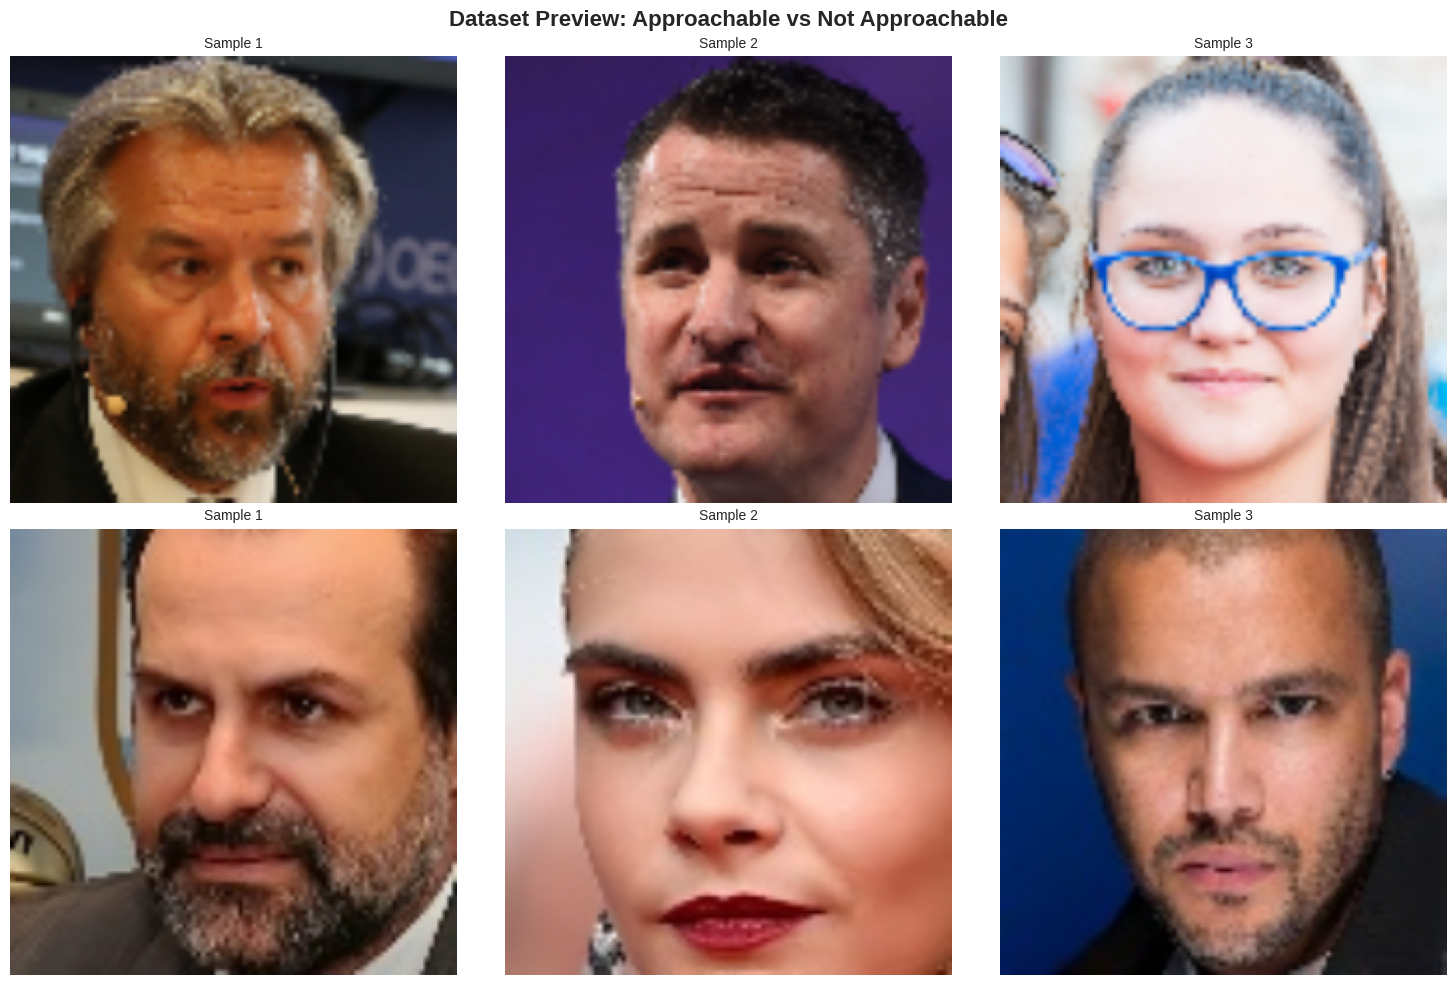


Displayed 3 samples from each class
Approachable samples: 800 total
Not Approachable samples: 800 total


14495

In [7]:
# Dataset Preview: Show sample images
def preview_dataset(X_images, y_labels, num_samples=3):
    """
    Display sample images from each class.

    Args:
        X_images: Array of images
        y_labels: Array of labels
        num_samples: Number of samples to show per class
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 10))
    fig.suptitle('Dataset Preview: Approachable vs Not Approachable', fontsize=16, fontweight='bold')

    # Approachable samples (Class 1)
    approachable_indices = np.where(y_labels == 1)[0]
    approachable_samples = np.random.choice(approachable_indices, num_samples, replace=False)

    axes[0, 0].set_ylabel('Approachable\n(Happy/Neutral)', fontsize=12, fontweight='bold')
    for idx, sample_idx in enumerate(approachable_samples):
        axes[0, idx].imshow(X_images[sample_idx])
        axes[0, idx].set_title(f'Sample {idx+1}', fontsize=10)
        axes[0, idx].axis('off')

    # Not Approachable samples (Class 0)
    not_approachable_indices = np.where(y_labels == 0)[0]
    not_approachable_samples = np.random.choice(not_approachable_indices, num_samples, replace=False)

    axes[1, 0].set_ylabel('Not Approachable\n(Angry/Contempt)', fontsize=12, fontweight='bold')
    for idx, sample_idx in enumerate(not_approachable_samples):
        axes[1, idx].imshow(X_images[sample_idx])
        axes[1, idx].set_title(f'Sample {idx+1}', fontsize=10)
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nDisplayed {num_samples} samples from each class")
    print(f"Approachable samples: {len(approachable_indices)} total")
    print(f"Not Approachable samples: {len(not_approachable_indices)} total")

# Display preview
preview_dataset(X_images, y_labels, num_samples=3)

# Free memory: raw data no longer needed (splits X_train_img, X_val_img, X_test_img, y_train, y_val, y_test kept)
del X_images, y_labels, X_images_normalized, X_temp, y_temp
gc.collect()

### tf.data API Setup for Efficient GPU Training

**Why tf.data API?**

- **Prefetching:** Overlaps data preprocessing and model execution, keeping GPU busy
- **Caching:** Stores preprocessed data in memory/disk, avoiding redundant preprocessing
- **Parallel Processing:** Uses multiple CPU cores for data loading
- **Memory Efficiency:** Optimizes data pipeline to reduce memory footprint

This is required by the rubric and significantly speeds up training on GPU.

In [8]:
# Create tf.data.Dataset for efficient GPU training
def create_tf_dataset(X, y, batch_size=32, shuffle=True, cache=True, prefetch=True):
    """
    Create optimized tf.data.Dataset for GPU training.

    Args:
        X: Image data
        y: Labels
        batch_size: Batch size
        shuffle: Whether to shuffle data
        cache: Whether to cache data in memory
        prefetch: Whether to prefetch batches

    Returns:
        tf.data.Dataset object
    """
    # Create dataset from tensors
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    # Shuffle if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, seed=42)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Cache in memory for faster access (if memory allows)
    if cache:
        dataset = dataset.cache()

    # Prefetch batches to keep GPU busy
    if prefetch:
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create optimized datasets for training and validation
print("Creating optimized tf.data datasets...")
train_dataset = create_tf_dataset(X_train_img, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(X_val_img, y_val, batch_size=BATCH_SIZE, shuffle=False)

# EfficientNet-preprocessed datasets for DL Experiment 1 (tf.data API training)
train_ds_eff = create_tf_dataset(X_train_eff, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_ds_eff = create_tf_dataset(X_val_eff, y_val, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training dataset created: {len(train_dataset)} batches")
print(f"Validation dataset created: {len(val_dataset)} batches")
print(f"EfficientNet tf.data (train_ds_eff, val_ds_eff): {len(train_ds_eff)} / {len(val_ds_eff)} batches")
print(f"tf.data API optimizations enabled:")
print(f"- Prefetching: Enabled (keeps GPU busy)")
print(f"- Caching: Enabled (faster data access)")
print(f"- Shuffling: Enabled for training")

Creating optimized tf.data datasets...
Training dataset created: 48 batches
Validation dataset created: 16 batches
EfficientNet tf.data (train_ds_eff, val_ds_eff): 48 / 16 batches
tf.data API optimizations enabled:
- Prefetching: Enabled (keeps GPU busy)
- Caching: Enabled (faster data access)
- Shuffling: Enabled for training


### Feature Extraction for Traditional ML

We extract two types of features for SVM models:

1. **HOG (Histogram of Oriented Gradients):** Captures edge and gradient information, effective for facial structure detection
2. **LBP (Local Binary Patterns):** Captures texture patterns, useful for facial expression recognition

### Why HOG and LBP?

- **HOG:** Well-established for object detection, captures spatial relationships in facial features
- **LBP:** Robust to illumination changes, captures local texture patterns important for emotion recognition
- **Combined:** Complementary features that together provide richer representation than either alone

In [9]:
# Memory-optimized feature extraction functions
# Images stay 224x224 RGB for EfficientNetB0, but resized temporarily to 128x128 for feature extraction
import gc
from skimage import feature

def extract_hog_features(images, batch_size=50):
    """Extract HOG features - resizes temporarily to 128x128 for memory efficiency."""
    hog_features = []
    hog = cv2.HOGDescriptor()

    # Process in batches to save memory
    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i+batch_size]
        batch_features = []

        for img in batch:
            # Temporary resize to 128x128 ONLY for HOG (original images stay 224x224)
            img_temp = cv2.resize((img * 255).astype('uint8'), (128, 128))
            gray = cv2.cvtColor(img_temp, cv2.COLOR_RGB2GRAY)
            features = hog.compute(gray)
            batch_features.append(features.flatten())
            del img_temp, gray  # Free immediately

        hog_features.extend(batch_features)
        del batch, batch_features
        gc.collect()  # Free memory after each batch

    return np.array(hog_features)

def extract_lbp_features(images, radius=1, n_points=8, batch_size=50):
    """Extract LBP features - resizes temporarily to 128x128 for memory efficiency."""
    lbp_features = []

    # Process in batches to save memory
    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i+batch_size]
        batch_features = []

        for img in batch:
            # Temporary resize to 128x128 ONLY for LBP (original images stay 224x224)
            img_temp = cv2.resize((img * 255).astype('uint8'), (128, 128))
            gray = cv2.cvtColor(img_temp, cv2.COLOR_RGB2GRAY)

            # Use skimage's efficient LBP implementation
            lbp = feature.local_binary_pattern(gray, n_points, radius, method='uniform')

            # Calculate histogram
            hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
            hist = hist.astype('float32')
            hist /= (hist.sum() + 1e-7)  # Normalize
            batch_features.append(hist)
            del img_temp, gray, lbp  # Free immediately

        lbp_features.extend(batch_features)
        del batch, batch_features
        gc.collect()  # Free memory after each batch

    return np.array(lbp_features)

# Extract features for training, validation, and test sets
# Process one set at a time and free memory to prevent RAM overflow
print("=" * 80)
print("MEMORY-OPTIMIZED FEATURE EXTRACTION")
print("=" * 80)

print("\nExtracting HOG features for training set...")
X_train_hog = extract_hog_features(X_train_img, batch_size=50)
gc.collect()

print("Extracting HOG features for validation set...")
X_val_hog = extract_hog_features(X_val_img, batch_size=50)
gc.collect()

print("Extracting HOG features for test set...")
X_test_hog = extract_hog_features(X_test_img, batch_size=50)
gc.collect()

print("\nExtracting LBP features for training set...")
X_train_lbp = extract_lbp_features(X_train_img, batch_size=50)
gc.collect()

print("Extracting LBP features for validation set...")
X_val_lbp = extract_lbp_features(X_val_img, batch_size=50)
gc.collect()

print("Extracting LBP features for test set...")
X_test_lbp = extract_lbp_features(X_test_img, batch_size=50)
gc.collect()

print(f"\nFeature extraction complete")
print(f"HOG feature shape: {X_train_hog.shape}")
print(f"LBP feature shape: {X_train_lbp.shape}")
print(f"\nMemory optimization: Images kept at 224x224 RGB for EfficientNetB0")
print(f" Feature extraction uses temporary 128x128 resize for memory efficiency")

MEMORY-OPTIMIZED FEATURE EXTRACTION

Extracting HOG features for training set...


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Extracting HOG features for validation set...


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


Extracting HOG features for test set...


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]



Extracting LBP features for training set...


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


Extracting LBP features for validation set...


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


Extracting LBP features for test set...


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Feature extraction complete
HOG feature shape: (960, 34020)
LBP feature shape: (960, 10)

Memory optimization: Images kept at 224x224 RGB for EfficientNetB0
 Feature extraction uses temporary 128x128 resize for memory efficiency


### HOG Preview: Sample Images and Their HOG Visualizations

Below we show 3 training images (top row) and their HOG descriptor visualizations (bottom row). HOG highlights gradient orientations and strengths, which the SVM uses as features.

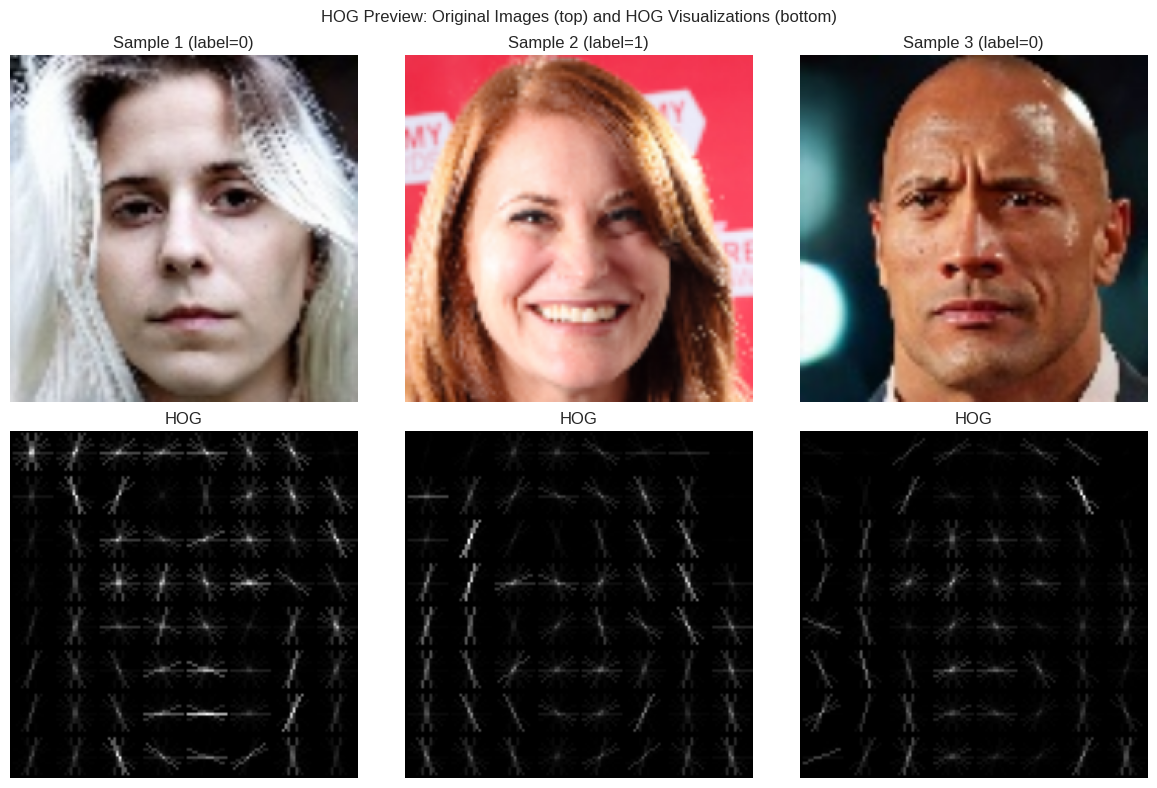

In [10]:
# HOG preview: 3 sample images and their HOG visualizations
# Use same 128x128 size as in extract_hog_features; skimage.hog gives a visualization image
HOG_SIZE = (128, 128)
n_preview = 3
indices = [0, len(X_train_img) // 2, min(len(X_train_img) - 1, len(X_train_img) // 4 * 3)]

fig, axes = plt.subplots(2, n_preview, figsize=(4 * n_preview, 8))
for col, idx in enumerate(indices):
    img = X_train_img[idx]
    # Grayscale at 128x128 (match HOG pipeline)
    if img.ndim == 3:
        gray = cv2.cvtColor((np.clip(img, 0, 1) * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else:
        gray = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    gray = cv2.resize(gray, HOG_SIZE)

    # HOG visualization (skimage)
    _, hog_img = feature.hog(
        gray, orientations=9, pixels_per_cell=(16, 16),
        cells_per_block=(2, 2), visualize=True, feature_vector=False
    )

    # Top row: original image (show RGB at 224 or resized for consistency)
    axes[0, col].imshow(img if img.ndim == 3 else gray, cmap='gray' if img.ndim == 2 else None)
    axes[0, col].set_title(f'Sample {col+1} (label={y_train[idx]})')
    axes[0, col].axis('off')
    # Bottom row: HOG
    axes[1, col].imshow(hog_img, cmap='gray')
    axes[1, col].set_title(f'HOG')
    axes[1, col].axis('off')

plt.suptitle('HOG Preview: Original Images (top) and HOG Visualizations (bottom)', fontsize=12)
plt.tight_layout()
plt.show()

## 3. Traditional ML: SVM Experiments

### Evaluation Metrics Explanation

We use the following metrics to comprehensively evaluate our models:

1. **Train Error & Validation Error:** Measure model fit and generalization
   - Large gap indicates overfitting
   - High error on both indicates underfitting

2. **AUC (Area Under ROC Curve):** Measures model's ability to distinguish between classes
   - Range: 0 to 1 (higher is better)
   - AUC = 0.5: Random classifier
   - AUC = 1.0: Perfect classifier
   - **Why:** Critical for binary classification, especially with imbalanced data

3. **Precision:** Of predicted "approachable", how many are actually approachable?
   - **Why:** Important to minimize false positives (approaching wrong person)

4. **Recall:** Of actual "approachable" cases, how many did we catch?
   - **Why:** Important to not miss opportunities (false negatives)

5. **Confusion Matrix:** Visual representation of classification errors
   - **Why:** Identifies which classes are confused and error patterns

### Experiment Strategy

Each experiment builds on the previous one, systematically exploring:
1. Baseline performance
2. Different feature types
3. Dimensionality reduction
4. Hyperparameter optimization
5. Class imbalance handling
6. Feature combinations

In [11]:
# Helper function for evaluation and visualization
def evaluate_svm_model(model, X_train, X_val, y_train, y_val, model_name):
    """
    Evaluate SVM model and return metrics DataFrame.

    Returns:
        metrics_df: DataFrame with all metrics
        predictions: Validation predictions
        probabilities: Validation prediction probabilities
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Probabilities (for AUC)
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
    except:
        # If no predict_proba, use decision function
        y_train_proba = model.decision_function(X_train)
        y_val_proba = model.decision_function(X_val)

    # Calculate metrics
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)

    try:
        auc = roc_auc_score(y_val, y_val_proba)
    except:
        auc = 0.5

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Train Error': [train_error],
        'Validation Error': [val_error],
        'AUC': [auc],
        'Precision': [precision],
        'Recall': [recall]
    })

    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Approachable', 'Approachable'],
                yticklabels=['Not Approachable', 'Approachable'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return metrics_df, y_val_pred, y_val_proba

# Store all results and model references for final test evaluation
svm_results = []
svm_models = []

### Experiment 1: SVM Baseline (RBF Kernel, Default Parameters)

**Justification:** Establish a baseline performance with default SVM parameters using RBF kernel, which is effective for non-linear classification problems. This provides a reference point for comparing subsequent experiments.

Experiment 1: SVM Baseline (RBF Kernel)
Training svm_baseline...
Training completed!


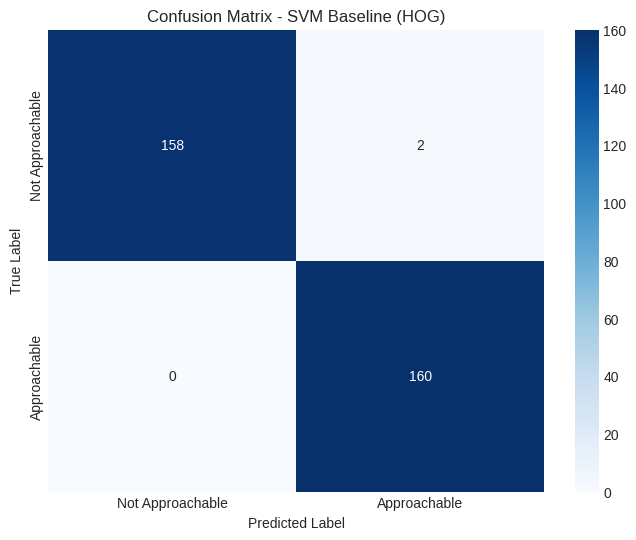


Metrics:
                Model  Train Error  Validation Error       AUC  Precision  \
0  SVM Baseline (HOG)          0.0           0.00625  0.998398   0.987654   

   Recall  
0     1.0  


In [12]:
# Standardize HOG features
scaler_hog = StandardScaler()
X_train_hog_scaled = scaler_hog.fit_transform(X_train_hog)
X_val_hog_scaled = scaler_hog.transform(X_val_hog)
X_test_hog_scaled = scaler_hog.transform(X_test_hog)

# Experiment 1: Baseline SVM with HOG features
print("Experiment 1: SVM Baseline (RBF Kernel)")
svm_baseline = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
print(f"Training svm_baseline...")
svm_baseline.fit(X_train_hog_scaled, y_train)
print("Training completed!")

# Evaluate
metrics_df_1, _, _ = evaluate_svm_model(svm_baseline, X_train_hog_scaled, X_val_hog_scaled,
                                         y_train, y_val, "SVM Baseline (HOG)")
svm_results.append(metrics_df_1)
svm_models.append(svm_baseline)
print("\nMetrics:")
print(metrics_df_1)

In [13]:
# Model kept in svm_models for final test set evaluation

In [14]:
import gc
gc.collect()

4463

### Experiment 2: SVM with LBP Features

**Justification:** Test LBP features which capture texture patterns differently than HOG. LBP is robust to illumination changes and may capture subtle facial expression variations better than gradient-based HOG features.

Experiment 2: SVM with LBP Features
Training svm_lbp...
Training completed!


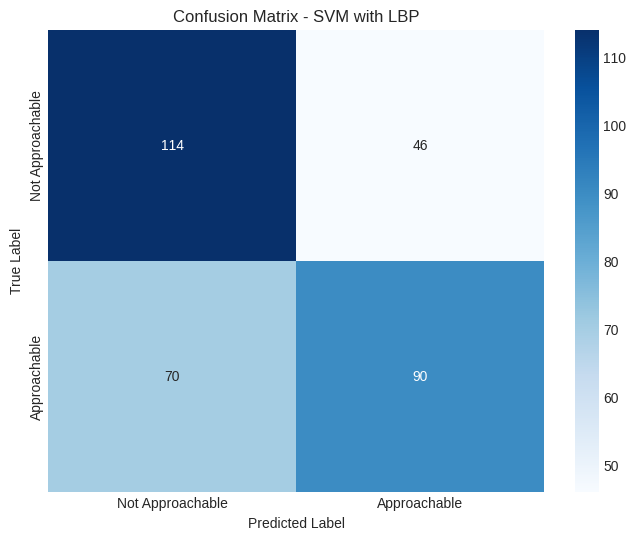


Metrics:
          Model  Train Error  Validation Error       AUC  Precision  Recall
0  SVM with LBP     0.317708            0.3625  0.682813   0.661765  0.5625


In [15]:
# Standardize LBP features
scaler_lbp = StandardScaler()
X_train_lbp_scaled = scaler_lbp.fit_transform(X_train_lbp)
X_val_lbp_scaled = scaler_lbp.transform(X_val_lbp)
X_test_lbp_scaled = scaler_lbp.transform(X_test_lbp)

# Experiment 2: SVM with LBP features
print("Experiment 2: SVM with LBP Features")
svm_lbp = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
print(f"Training svm_lbp...")
svm_lbp.fit(X_train_lbp_scaled, y_train)
print("Training completed!")

# Evaluate
metrics_df_2, _, _ = evaluate_svm_model(svm_lbp, X_train_lbp_scaled, X_val_lbp_scaled,
                                         y_train, y_val, "SVM with LBP")
svm_results.append(metrics_df_2)
svm_models.append(svm_lbp)
print("\nMetrics:")
print(metrics_df_2)

In [16]:
# Model kept in svm_models for final test set evaluation

In [17]:
import gc
gc.collect()

4455

### Experiment 3: SVM with PCA Dimensionality Reduction

**Justification:** Reduce feature dimensionality to eliminate noise and redundant information. PCA can improve model generalization by focusing on the most informative features, potentially reducing overfitting and training time.

Experiment 3: SVM with PCA Dimensionality Reduction
Original feature dimension: 34020
PCA reduced dimension: 665
Variance retained: 0.9501
Training svm_pca...
Training completed!


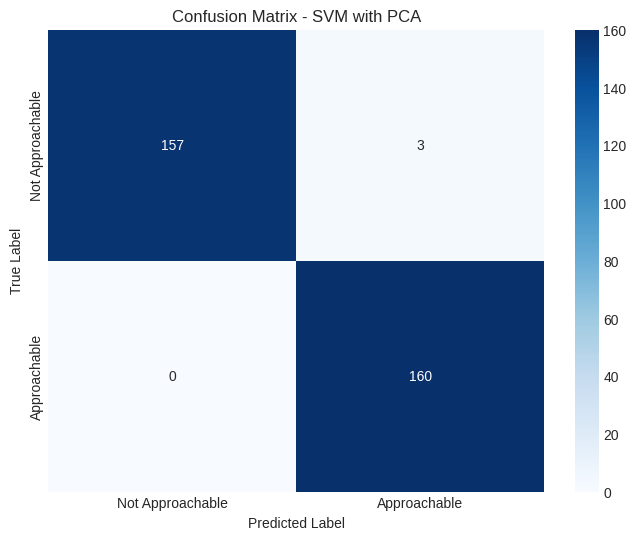


Metrics:
          Model  Train Error  Validation Error       AUC  Precision  Recall
0  SVM with PCA          0.0          0.009375  0.998633   0.981595     1.0


In [18]:
# Experiment 3: PCA dimensionality reduction (retain 95% variance)
print("Experiment 3: SVM with PCA Dimensionality Reduction")
pca = PCA(n_components=0.95, random_state=42)
X_train_hog_pca = pca.fit_transform(X_train_hog_scaled)
X_val_hog_pca = pca.transform(X_val_hog_scaled)
X_test_hog_pca = pca.transform(X_test_hog_scaled)

print(f"Original feature dimension: {X_train_hog_scaled.shape[1]}")
print(f"PCA reduced dimension: {X_train_hog_pca.shape[1]}")
print(f"Variance retained: {pca.explained_variance_ratio_.sum():.4f}")

svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
print(f"Training svm_pca...")
svm_pca.fit(X_train_hog_pca, y_train)
print("Training completed!")

# Evaluate
metrics_df_3, _, _ = evaluate_svm_model(svm_pca, X_train_hog_pca, X_val_hog_pca,
                                         y_train, y_val, "SVM with PCA")
svm_results.append(metrics_df_3)
svm_models.append(svm_pca)
print("\nMetrics:")
print(metrics_df_3)

In [19]:
# Model kept in svm_models for final test set evaluation

In [20]:
import gc
gc.collect()

4485

### Experiment 4: SVM with Class Weights (Balanced)

**Justification:** Handle potential class imbalance by assigning higher weights to minority class samples. This prevents the model from being biased toward the majority class and improves recall for the minority class.

Experiment 4: SVM with Class Weights (Balanced)
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Training svm_balanced...
Training completed!


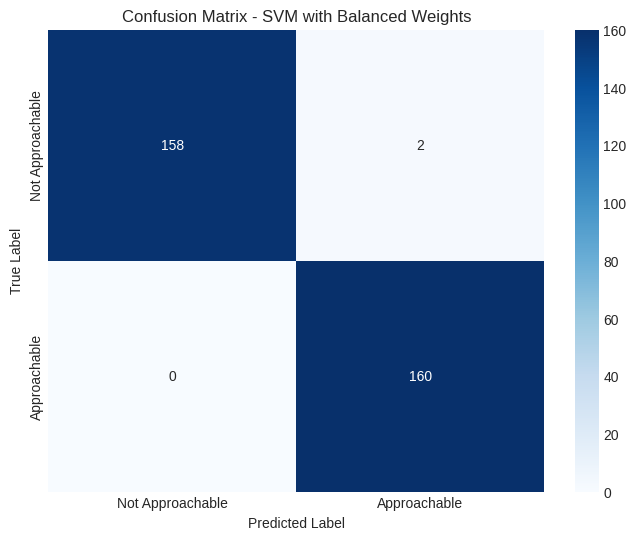


Metrics:
                       Model  Train Error  Validation Error       AUC  \
0  SVM with Balanced Weights          0.0           0.00625  0.998398   

   Precision  Recall  
0   0.987654     1.0  


In [21]:
# Experiment 4: SVM with balanced class weights
print("Experiment 4: SVM with Class Weights (Balanced)")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights: {class_weight_dict}")

svm_balanced = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,
                   class_weight='balanced', random_state=42)
print(f"Training svm_balanced...")
svm_balanced.fit(X_train_hog_scaled, y_train)
print("Training completed!")

# Evaluate
metrics_df_4, _, _ = evaluate_svm_model(svm_balanced, X_train_hog_scaled, X_val_hog_scaled,
                                         y_train, y_val, "SVM with Balanced Weights")
svm_results.append(metrics_df_4)
svm_models.append(svm_balanced)
print("\nMetrics:")
print(metrics_df_4)

In [22]:
# Model kept in svm_models for final test set evaluation

In [23]:
import gc
gc.collect()

4479


### Experiment 5: SVM with Combined Features (HOG + LBP)

**Justification:** Combine complementary features (HOG for structure, LBP for texture) to create a richer feature representation. This leverages the strengths of both feature types and may improve classification performance.

### GPU Optimization Notes for Deep Learning Models

**All deep learning models will use:**
1. **tf.data API:** Use `train_dataset` and `val_dataset` instead of raw arrays for faster GPU training
2. **Mixed Precision:** Already enabled globally - output layers use `dtype='float32'` for stability
3. **Batch Size:** 32 (optimized for GPU memory)
4. **Epochs:** 10 (sufficient for convergence with transfer learning)

**Expected Speedup:** 2-3x faster training compared to CPU-only with standard data loading.

Experiment 5: SVM with Combined Features (HOG + LBP)
Combined feature dimension: 34030
Training svm_combined...
Training completed!


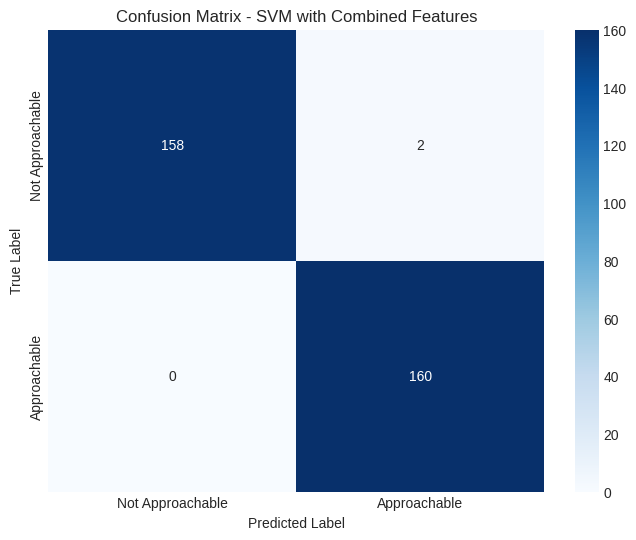


Metrics:
                        Model  Train Error  Validation Error       AUC  \
0  SVM with Combined Features          0.0           0.00625  0.998398   

   Precision  Recall  
0   0.987654     1.0  


In [24]:
# Experiment 5: Combine HOG and LBP features
print("Experiment 5: SVM with Combined Features (HOG + LBP)")

# Combine features
X_train_combined = np.hstack([X_train_hog_scaled, X_train_lbp_scaled])
X_val_combined = np.hstack([X_val_hog_scaled, X_val_lbp_scaled])
X_test_combined = np.hstack([X_test_hog_scaled, X_test_lbp_scaled])

print(f"Combined feature dimension: {X_train_combined.shape[1]}")

svm_combined = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
print(f"Training svm_combined...")
svm_combined.fit(X_train_combined, y_train)
print("Training completed!")

# Evaluate
metrics_df_5, _, _ = evaluate_svm_model(svm_combined, X_train_combined, X_val_combined,
                                         y_train, y_val, "SVM with Combined Features")
svm_results.append(metrics_df_5)
svm_models.append(svm_combined)
print("\nMetrics:")
print(metrics_df_5)

In [25]:
# Model kept in svm_models for final test set evaluation

### SVM Results Summary & Best Model Selection

Compare all 5 SVM experiments to identify the best performing model based on validation metrics.

SVM EXPERIMENTS SUMMARY

                     Model  Train Error  Validation Error      AUC  Precision  Recall
        SVM Baseline (HOG)     0.000000          0.006250 0.998398   0.987654  1.0000
              SVM with LBP     0.317708          0.362500 0.682813   0.661765  0.5625
              SVM with PCA     0.000000          0.009375 0.998633   0.981595  1.0000
 SVM with Balanced Weights     0.000000          0.006250 0.998398   0.987654  1.0000
SVM with Combined Features     0.000000          0.006250 0.998398   0.987654  1.0000

 BEST SVM MODEL (by validation AUC)

Model               SVM with PCA
Train Error                  0.0
Validation Error        0.009375
AUC                     0.998633
Precision               0.981595
Recall                       1.0
Name: 2, dtype: object


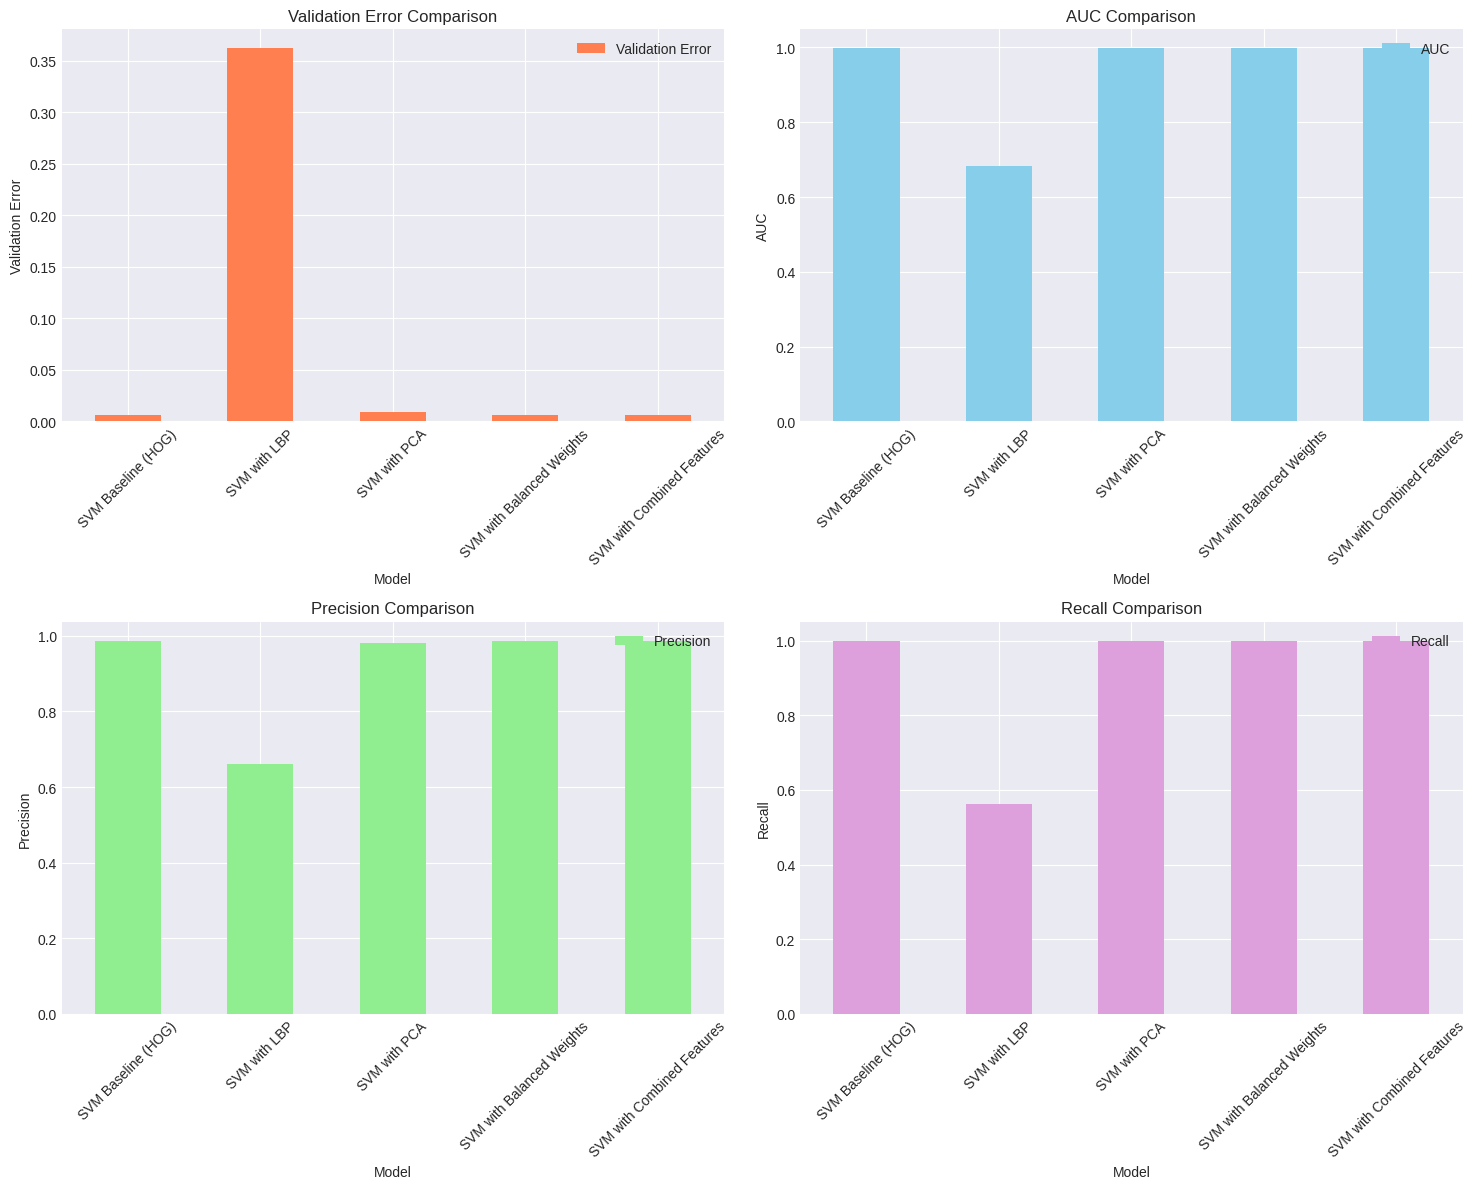

In [26]:
# Combine all SVM results
svm_summary = pd.concat(svm_results, ignore_index=True)
print("SVM EXPERIMENTS SUMMARY\n")
print(svm_summary.to_string(index=False))

# Find best model (by validation AUC)
best_svm_idx = svm_summary['AUC'].idxmax()
best_svm_model = svm_summary.iloc[best_svm_idx]

# Test feature arrays for each experiment (for final test evaluation)
svm_test_features = [X_test_hog_scaled, X_test_lbp_scaled, X_test_hog_pca, X_test_hog_scaled,
                     X_test_combined, X_test_hog_scaled, X_test_hog_scaled]

print("=" * 80)
print("\n BEST SVM MODEL (by validation AUC)\n")
print(best_svm_model)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Validation Error comparison
svm_summary.plot(x='Model', y='Validation Error', kind='bar', ax=axes[0,0], color='coral')
axes[0,0].set_title('Validation Error Comparison')
axes[0,0].set_ylabel('Validation Error')
axes[0,0].tick_params(axis='x', rotation=45)

# AUC comparison
svm_summary.plot(x='Model', y='AUC', kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('AUC Comparison')
axes[0,1].set_ylabel('AUC')
axes[0,1].tick_params(axis='x', rotation=45)

# Precision comparison
svm_summary.plot(x='Model', y='Precision', kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Precision Comparison')
axes[1,0].set_ylabel('Precision')
axes[1,0].tick_params(axis='x', rotation=45)

# Recall comparison
svm_summary.plot(x='Model', y='Recall', kind='bar', ax=axes[1,1], color='plum')
axes[1,1].set_title('Recall Comparison')
axes[1,1].set_ylabel('Recall')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Final SVM Test Set Evaluation

Evaluate the **best** SVM model (chosen by validation AUC) on the **held-out test set** once. This gives an unbiased estimate of generalization performance.

BEST SVM MODEL — TEST SET PERFORMANCE (held-out, no selection on test)
Model: SVM with PCA
Test Accuracy:  0.9906
Test F1:        0.9907
Test Precision: 0.9816
Test Recall:    1.0000
Test AUC:       0.9996



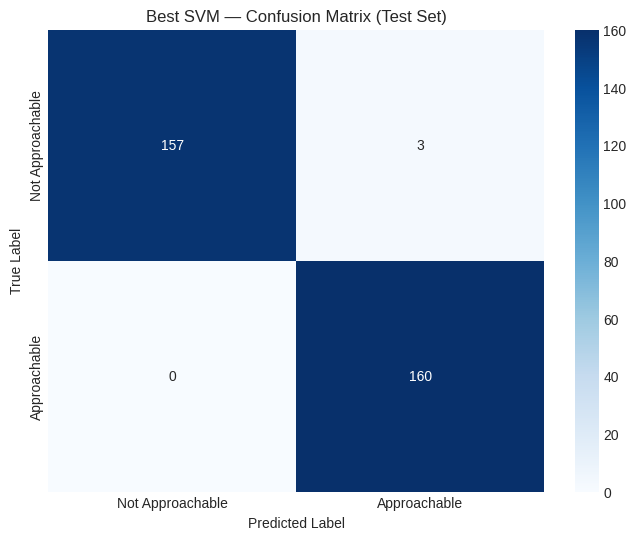

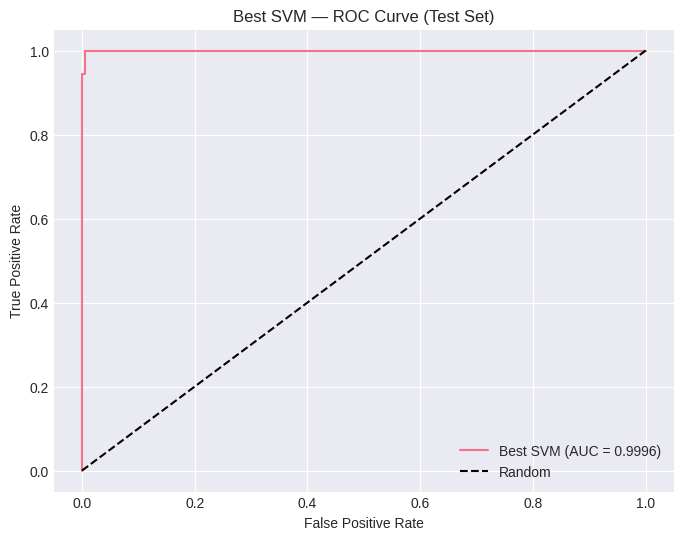

In [27]:
# Best SVM: final evaluation on TEST set (single evaluation, no model selection on test)
best_svm_actual = svm_models[best_svm_idx]
X_test_svm = svm_test_features[best_svm_idx]

y_test_pred_svm = best_svm_actual.predict(X_test_svm)
y_test_proba_svm = best_svm_actual.predict_proba(X_test_svm)[:, 1]

test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='binary', zero_division=0)
test_precision_svm = precision_score(y_test, y_test_pred_svm, average='binary', zero_division=0)
test_recall_svm = recall_score(y_test, y_test_pred_svm, average='binary', zero_division=0)
test_auc_svm = roc_auc_score(y_test, y_test_proba_svm)

print("=" * 80)
print("BEST SVM MODEL — TEST SET PERFORMANCE (held-out, no selection on test)")
print("=" * 80)
print(f"Model: {best_svm_model['Model']}")
print(f"Test Accuracy:  {test_acc_svm:.4f}")
print(f"Test F1:        {test_f1_svm:.4f}")
print(f"Test Precision: {test_precision_svm:.4f}")
print(f"Test Recall:    {test_recall_svm:.4f}")
print(f"Test AUC:       {test_auc_svm:.4f}")
print()

# Confusion matrix on test
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approachable', 'Approachable'],
            yticklabels=['Not Approachable', 'Approachable'])
plt.title('Best SVM — Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve on test
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_proba_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'Best SVM (AUC = {test_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best SVM — ROC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Deleting all the SVM models after final evaluation
# Free memory: SVM model objects no longer needed (metrics/results kept for final comparison)
del svm_models, best_svm_actual, svm_test_features
gc.collect()
print("SVM models and test features freed.")

SVM models and test features freed.


## 4. Deep Learning Experiments

### Why Deep Learning?

Deep learning models can automatically learn hierarchical feature representations from raw images, potentially capturing more complex patterns than hand-crafted features. We compare:
- **Sequential API:** Simple, layer-by-layer model construction
- **Functional API:** More flexible, enables transfer learning and complex architectures

### Evaluation Metrics (Same as SVM)

All models evaluated using: Train Error, Validation Error, AUC, Precision, Recall

In [29]:
# Helper function for deep learning evaluation
def evaluate_dl_model(model, history, X_train, X_val, y_train, y_val, model_name):
    """
    Evaluate deep learning model and return metrics DataFrame.

    Returns:
        metrics_df: DataFrame with all metrics
    """
    # Predictions
    y_train_pred_proba = model.predict(X_train, verbose=0)
    y_val_pred_proba = model.predict(X_val, verbose=0)

    y_train_pred = (y_train_pred_proba > 0.5).astype(int).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()

    # Calculate metrics
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_val, y_val_pred_proba)

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'Train Error': [train_error],
        'Validation Error': [val_error],
        'AUC': [auc],
        'Precision': [precision],
        'Recall': [recall]
    })

    # Plot learning curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_title(f'Learning Curves - Loss ({model_name})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[1].set_title(f'Learning Curves - Accuracy ({model_name})')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Approachable', 'Approachable'],
                yticklabels=['Not Approachable', 'Approachable'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics_df

# Store all DL results and model references for final test evaluation
dl_results = []
dl_models = []

### Experiment 1: EfficientNetB0 Transfer Learning (Functional API) - Baseline

**Justification:** Use EfficientNetB0 pre-trained on ImageNet as a feature extractor. Transfer learning leverages learned features from a large dataset, typically improving performance with less training data and faster convergence. EfficientNetB0 is chosen for its balance between accuracy and efficiency.

Experiment 1: EfficientNetB0 Transfer Learning (Baseline)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 422ms/step - accuracy: 0.7225 - loss: 0.5135 - val_accuracy: 0.8875 - val_loss: 0.3111
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9227 - loss: 0.2128 - val_accuracy: 0.9312 - val_loss: 0.2240
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9598 - loss: 0.1393 - val_accuracy: 0.9250 - val_loss: 0.2072
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9681 - loss: 0.1135 - val_accuracy: 0.9219 - val_loss: 0.2006
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9820 - loss: 0.0821 - val_accuracy: 0.9438 - val_loss: 0.1892
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9788 - loss: 0.0756 - val_accuracy: 0.9469 - val_loss: 0.1905
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9907 - loss: 0.0529 - val_accuracy: 0.9281 - val_loss: 0.1949
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9933 - loss: 0.0504 - val_accuracy: 0.9

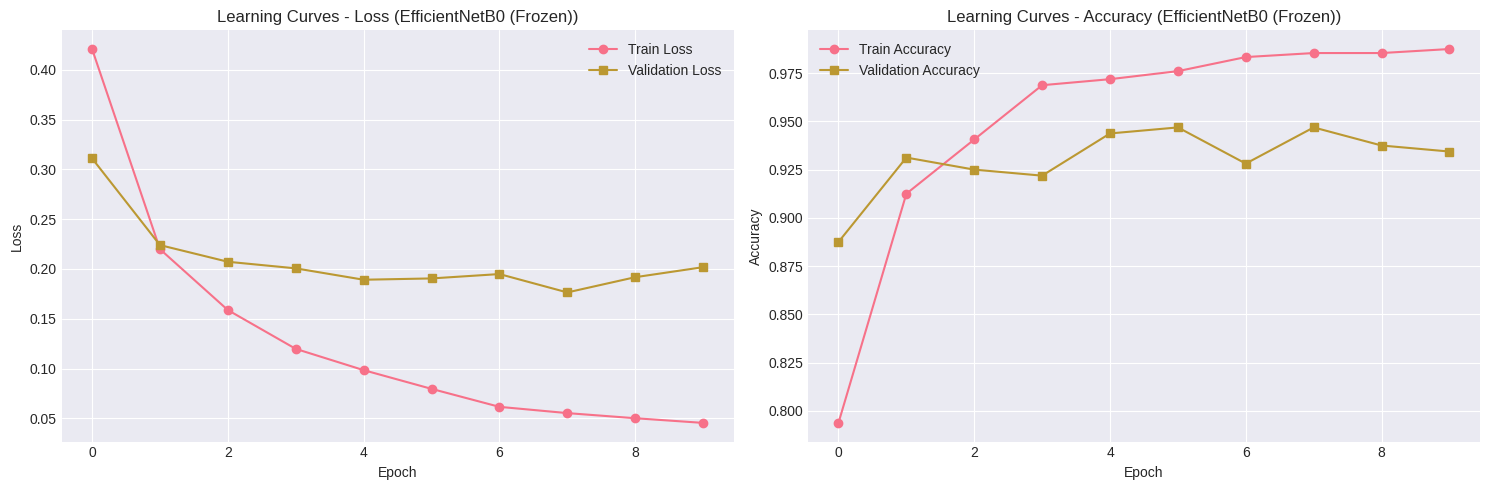

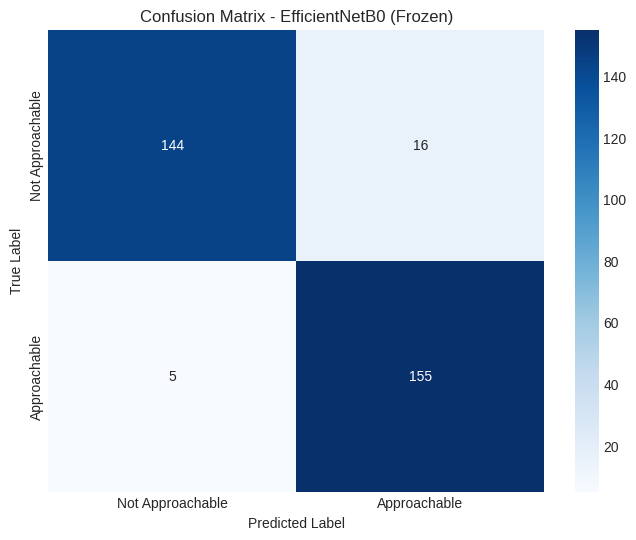

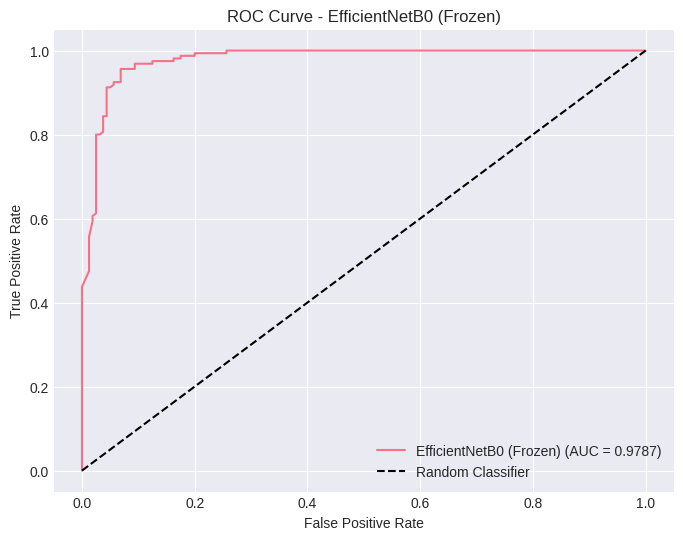


Metrics:
                     Model  Train Error  Validation Error      AUC  Precision  \
0  EfficientNetB0 (Frozen)     0.004167          0.065625  0.97873   0.906433   

    Recall  
0  0.96875  


In [30]:
# Experiment 1: EfficientNetB0 Transfer Learning (Functional API)
print("Experiment 1: EfficientNetB0 Transfer Learning (Baseline)")

# Load EfficientNetB0 base model (pre-trained on ImageNet)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Build model using Functional API
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model1 = keras.Model(inputs, outputs)

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

# Train with tf.data API (EfficientNet-preprocessed pipelines)
history1 = model1.fit(
    train_ds_eff,
    epochs=EPOCHS,
    validation_data=val_ds_eff,
    verbose=1
)

# Evaluate
metrics_df_dl1 = evaluate_dl_model(model1, history1, X_train_eff, X_val_eff,
                                    y_train, y_val, "EfficientNetB0 (Frozen)")
dl_results.append(metrics_df_dl1)
dl_models.append(model1)
print("\nMetrics:")
print(metrics_df_dl1)

In [31]:
# Keep model in dl_models for final test evaluation; clear base to free memory
del base_model
import gc
gc.collect()

14961

### Experiment 2: EfficientNetB0 with Fine-tuning

**Justification:** Unfreeze top layers of EfficientNetB0 to fine-tune pre-trained features for our specific task. Fine-tuning allows the model to adapt ImageNet features to facial expression recognition, potentially improving performance over frozen transfer learning.

Experiment 2: EfficientNetB0 with Fine-tuning
Trainable layers: 6
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 492ms/step - accuracy: 0.5900 - loss: 0.6571 - val_accuracy: 0.8156 - val_loss: 0.5061
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9180 - loss: 0.3738 - val_accuracy: 0.9312 - val_loss: 0.2865
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9540 - loss: 0.2055 - val_accuracy: 0.9500 - val_loss: 0.1861
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9771 - loss: 0.1225 - val_accuracy: 0.9688 - val_loss: 0.1302
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9824 - loss: 0.0788 - val_accuracy: 0.9750 - val_loss: 0.0943
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9869 - loss: 0.0567 - val_accuracy: 0.9875 - val_loss: 0.0758
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9953 - loss: 0.0346 - val_accuracy: 0.9844 - val_loss: 0.0660
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19

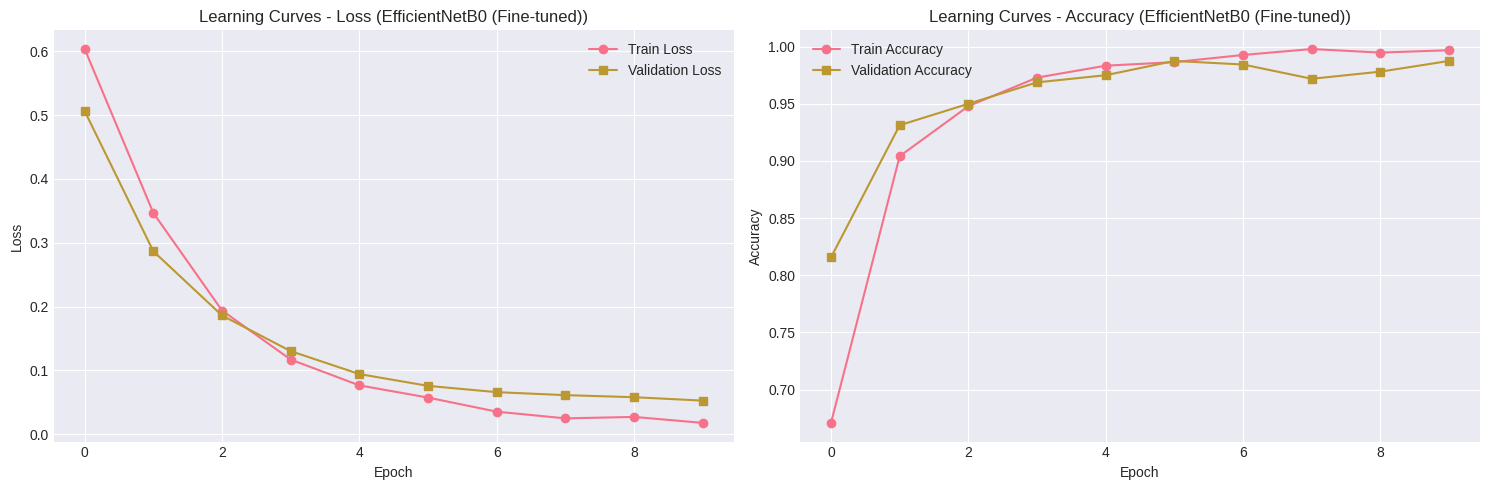

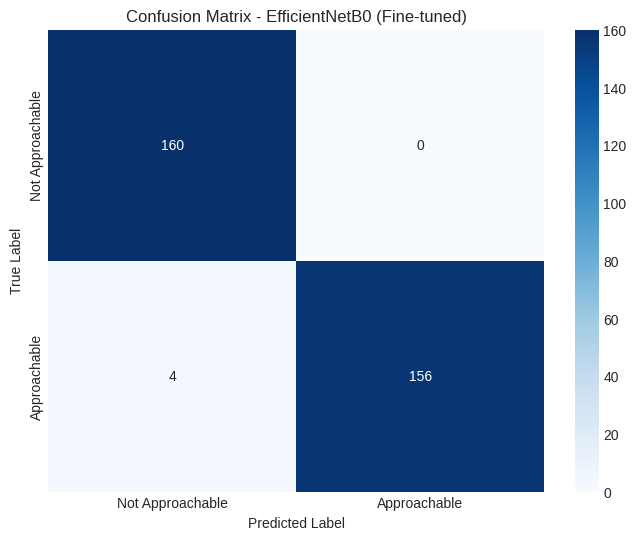

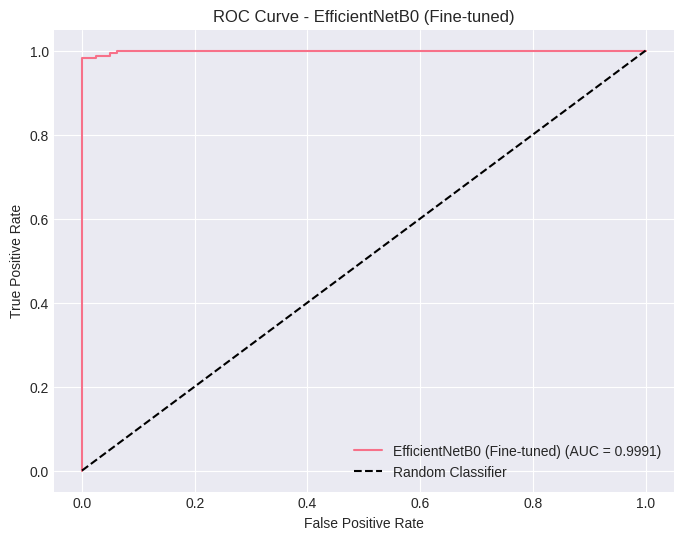


Metrics:
                         Model  Train Error  Validation Error       AUC  \
0  EfficientNetB0 (Fine-tuned)     0.001042            0.0125  0.999141   

   Precision  Recall  
0        1.0   0.975  


In [32]:
# Experiment 2: EfficientNetB0 with Fine-tuning
print("Experiment 2: EfficientNetB0 with Fine-tuning")

# Load EfficientNetB0 base model
base_model2 = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Unfreeze top layers for fine-tuning
base_model2.trainable = True
# Freeze bottom layers, fine-tune top layers
for layer in base_model2.layers[:-30]:
    layer.trainable = False

# Build model
inputs2 = keras.Input(shape=(224, 224, 3))
x2 = base_model2(inputs2, training=True)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)
outputs3 = layers.Dense(1, activation='sigmoid')(x2)

model2 = keras.Model(inputs2, outputs3)

# Use lower learning rate for fine-tuning
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable layers: {sum([layer.trainable for layer in model2.layers])}")

# Train model (use ImageNet-preprocessed data)
history2 = model2.fit(
    X_train_eff, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_eff, y_val),
    verbose=1
)

# Evaluate
metrics_df_dl2 = evaluate_dl_model(model2, history2, X_train_eff, X_val_eff,
                                    y_train, y_val, "EfficientNetB0 (Fine-tuned)")
dl_results.append(metrics_df_dl2)
dl_models.append(model2)
print("\nMetrics:")
print(metrics_df_dl2)

In [33]:
# Keep model in dl_models for test evaluation; free base model
del base_model2
import gc
gc.collect()

15354

In [34]:
# Free memory: delete only train/val feature arrays (keep models, splits, scalers, pca, test features, results)
print("Freeing SVM train/val feature arrays (keeping models, results, test data)...")

# Train/val only (keep X_test_*, scalers, pca, svm_models, svm_results for final comparison)
def _del_if_exists(name):
    if name in globals(): del globals()[name]
for _n in ['X_train_hog', 'X_val_hog', 'X_train_lbp', 'X_val_lbp', 'X_train_hog_scaled', 'X_val_hog_scaled',
           'X_train_lbp_scaled', 'X_val_lbp_scaled', 'X_train_hog_pca', 'X_val_hog_pca', 'X_train_combined', 'X_val_combined']:
    _del_if_exists(_n)

import gc
gc.collect()
print("SVM train/val arrays freed; models, results, and test data kept.")

Freeing SVM train/val feature arrays (keeping models, results, test data)...
SVM train/val arrays freed; models, results, and test data kept.


### Experiment 3: EfficientNetB0 with Data Augmentation

**Justification:** Apply data augmentation (rotation, flipping, brightness/contrast adjustments) to increase dataset diversity and improve model generalization. Augmentation helps prevent overfitting and makes the model more robust to variations in real-world images.

Experiment 3: EfficientNetB0 with Data Augmentation
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 668ms/step - accuracy: 0.6512 - loss: 0.5810 - val_accuracy: 0.8188 - val_loss: 0.4168
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.8666 - loss: 0.3126 - val_accuracy: 0.8938 - val_loss: 0.2870
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.8970 - loss: 0.2205 - val_accuracy: 0.8969 - val_loss: 0.2627
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.9018 - loss: 0.2228 - val_accuracy: 0.9125 - val_loss: 0.2439
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.9158 - loss: 0.2306 - val_accuracy: 0.9062 - val_loss: 0.2283
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.9004 - loss: 0.2235 - val_accuracy: 0.9062 - val_loss: 0.2163
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9374 - loss: 0.1540 - val_accuracy: 0.9406 - val_loss: 0.1905
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 268

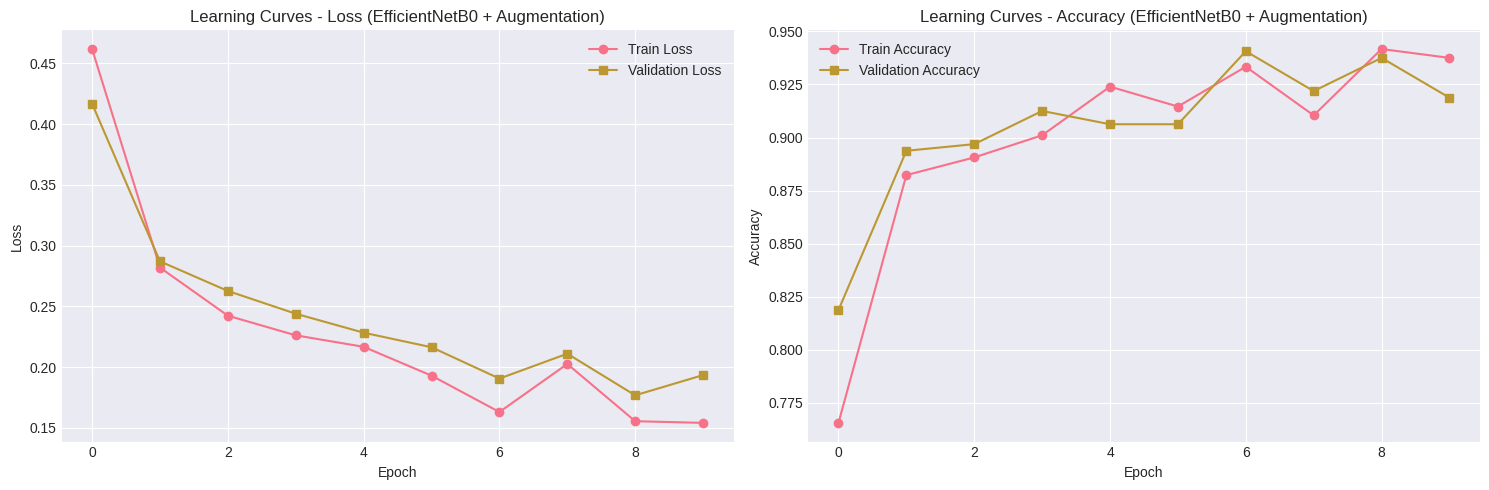

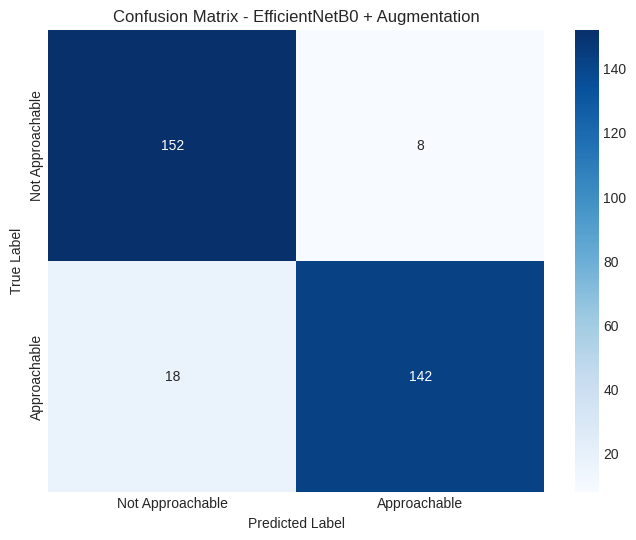

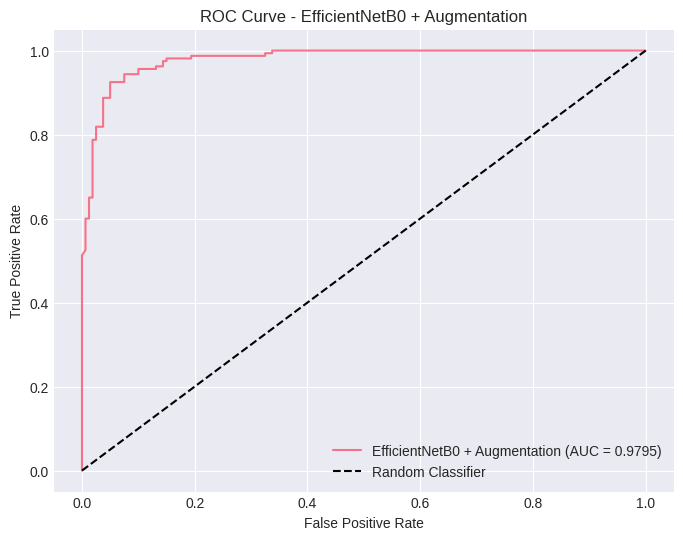


Metrics:
                           Model  Train Error  Validation Error       AUC  \
0  EfficientNetB0 + Augmentation     0.040625           0.08125  0.979492   

   Precision  Recall  
0   0.946667  0.8875  


15912

In [35]:
# Experiment 3: EfficientNetB0 with Data Augmentation
print("Experiment 3: EfficientNetB0 with Data Augmentation")

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2
)

# Load EfficientNetB0 base model
base_model3 = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model3.trainable = False

# Build model
inputs3 = keras.Input(shape=(224, 224, 3))
x3 = base_model3(inputs3, training=False)
x3 = layers.GlobalAveragePooling2D()(x3)
x3 = layers.Dense(128, activation='relu')(x3)
x3 = layers.Dropout(0.2)(x3)
outputs3 = layers.Dense(1, activation='sigmoid')(x3)

model3 = keras.Model(inputs3, outputs3)

model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with augmentation (use ImageNet-preprocessed data)
train_gen = datagen.flow(X_train_eff, y_train, batch_size=BATCH_SIZE)

history3 = model3.fit(
    train_gen,
    steps_per_epoch=len(X_train_eff) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_eff, y_val),
    verbose=1
)

# Evaluate
metrics_df_dl3 = evaluate_dl_model(model3, history3, X_train_eff, X_val_eff,
                                    y_train, y_val, "EfficientNetB0 + Augmentation")
dl_results.append(metrics_df_dl3)
dl_models.append(model3)
print("\nMetrics:")
print(metrics_df_dl3)

# Keep model in dl_models; free base
del base_model3
import gc
gc.collect()

### Experiment 4: EfficientNetB0 with Adam Optimizer (Different Learning Rate)

**Justification:** Compare Adam optimizer with different learning rates to find optimal convergence. Lower learning rates may provide more stable training, while higher rates may converge faster but risk overshooting optimal weights.

Experiment 4: EfficientNetB0 with Adam Optimizer (LR=0.0001)
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 428ms/step - accuracy: 0.6215 - loss: 0.6501 - val_accuracy: 0.7719 - val_loss: 0.5208
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7835 - loss: 0.4927 - val_accuracy: 0.8094 - val_loss: 0.4377
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8465 - loss: 0.3956 - val_accuracy: 0.8375 - val_loss: 0.3857
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8902 - loss: 0.3341 - val_accuracy: 0.8594 - val_loss: 0.3482
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8881 - loss: 0.3070 - val_accuracy: 0.8813 - val_loss: 0.3220
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9145 - loss: 0.2709 - val_accuracy: 0.8969 - val_loss: 0.3003
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9209 - loss: 0.2467 - val_accuracy: 0.8938 - val_loss: 0.2853
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

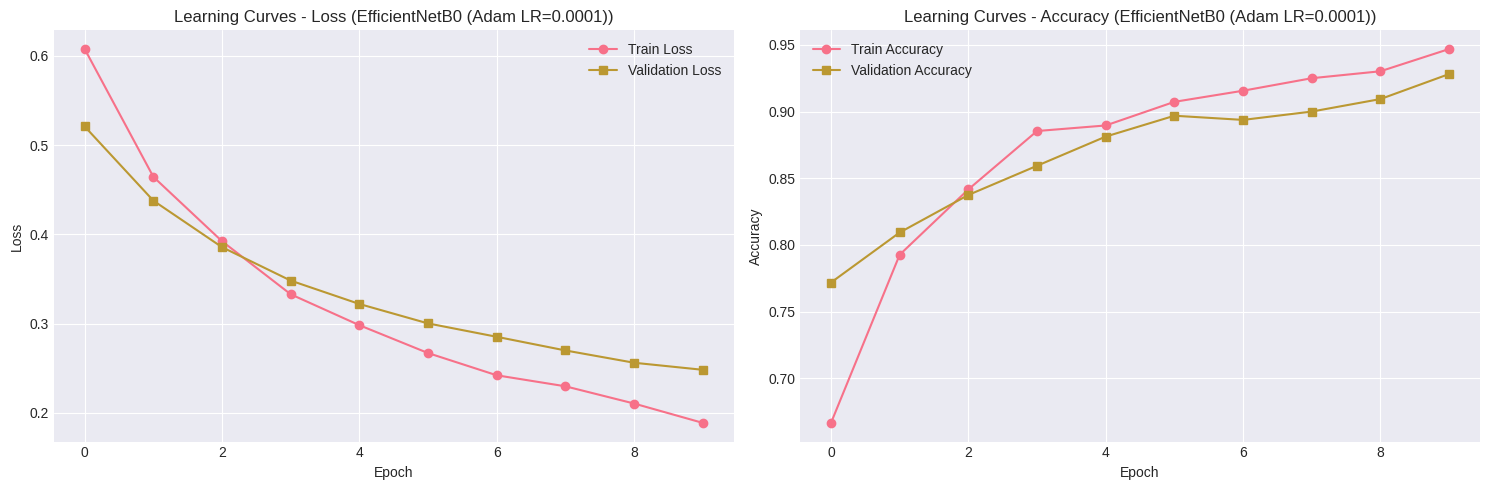

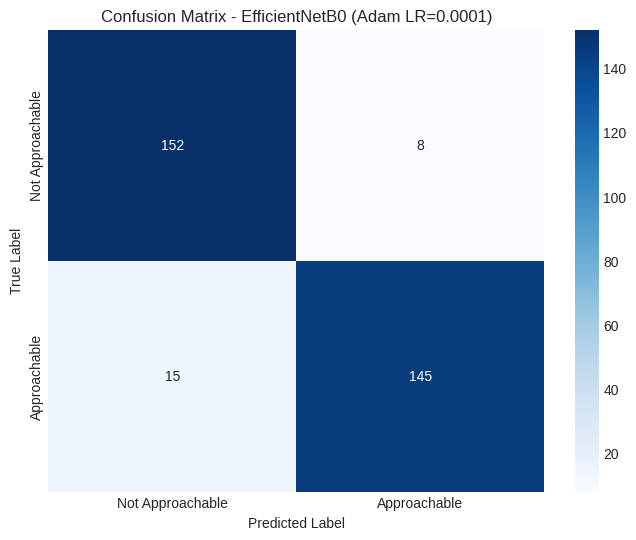

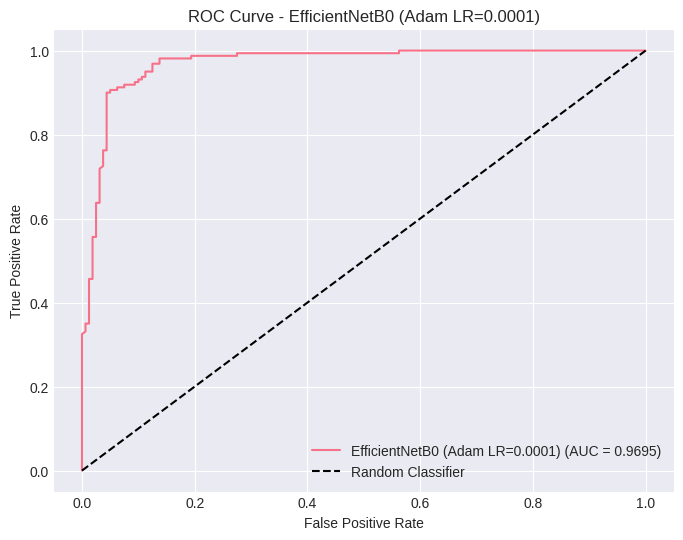


Metrics:
                             Model  Train Error  Validation Error       AUC  \
0  EfficientNetB0 (Adam LR=0.0001)     0.042708          0.071875  0.969492   

   Precision   Recall  
0   0.947712  0.90625  


15332

In [36]:
# Experiment 4: EfficientNetB0 with Adam (Lower Learning Rate)
print("Experiment 4: EfficientNetB0 with Adam Optimizer (LR=0.0001)")

base_model4 = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model4.trainable = False

inputs4 = keras.Input(shape=(224, 224, 3))
x4 = base_model4(inputs4, training=False)
x4 = layers.GlobalAveragePooling2D()(x4)
x4 = layers.Dense(128, activation='relu')(x4)
x4 = layers.Dropout(0.2)(x4)
outputs4 = layers.Dense(1, activation='sigmoid')(x4)

model4 = keras.Model(inputs4, outputs4)

# Use lower learning rate
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    X_train_eff, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_eff, y_val),
    verbose=1
)

# Evaluate
metrics_df_dl4 = evaluate_dl_model(model4, history4, X_train_eff, X_val_eff,
                                    y_train, y_val, "EfficientNetB0 (Adam LR=0.0001)")
dl_results.append(metrics_df_dl4)
dl_models.append(model4)
print("\nMetrics:")
print(metrics_df_dl4)

# Keep model in dl_models; free base
del base_model4
import gc
gc.collect()

### Experiment 5: Simple CNN with Dropout/Regularization

**Justification:** Add dropout layers and L2 regularization to the simple CNN to reduce overfitting. Regularization techniques help the model generalize better by preventing it from memorizing training data patterns.

Experiment 5: Simple CNN with Dropout/Regularization


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,132,033 (42.47 MB)

 Trainable params: 11,132,033 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.5086 - loss: 7.5150 - val_accuracy: 0.5000 - val_loss: 8.1834
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5178 - loss: 7.8633 - val_accuracy: 0.5000 - val_loss: 8.0787
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5178 - loss: 7.7812 - val_accuracy: 0.5000 - val_loss: 8.0320
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5178 - loss: 7.7399 - val_accuracy: 0.5000 - val_loss: 8.0081
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5178 - loss: 7.6713 - val_accuracy: 0.5000 - val_loss: 7.9952
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5228 - loss: 6.5281 - val_accuracy: 0.5000 - val_loss: 0.8011
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4771 - loss: 0.7775 - val_accuracy: 0.5000 - val_loss: 0.7301
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4822 - loss: 0.7245 - val_accuracy: 0.50

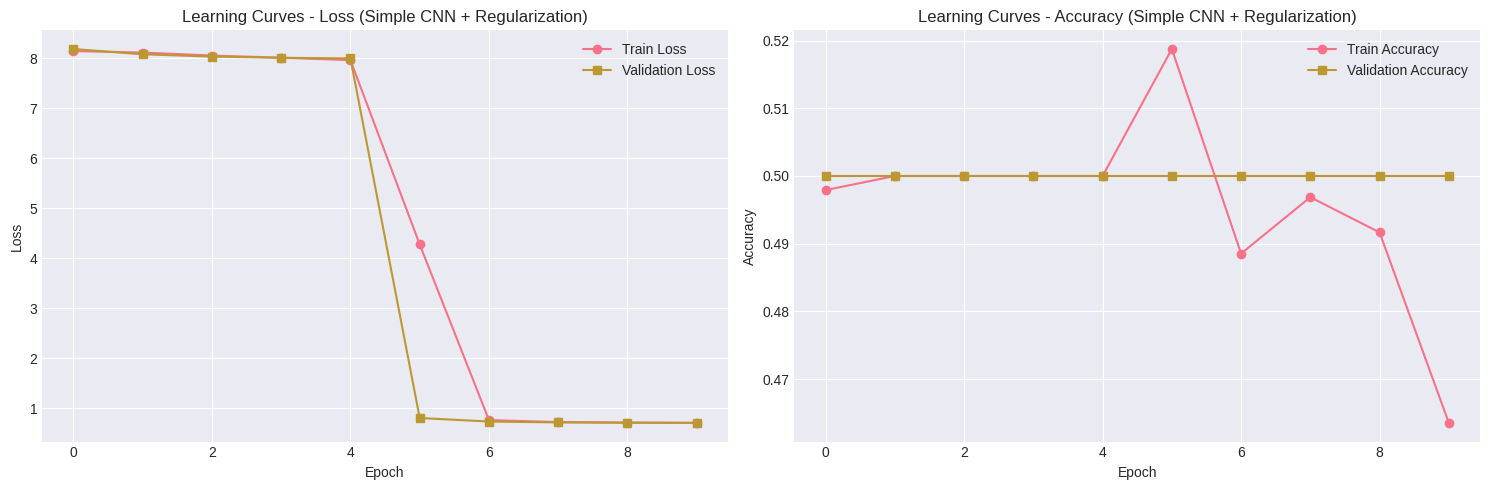

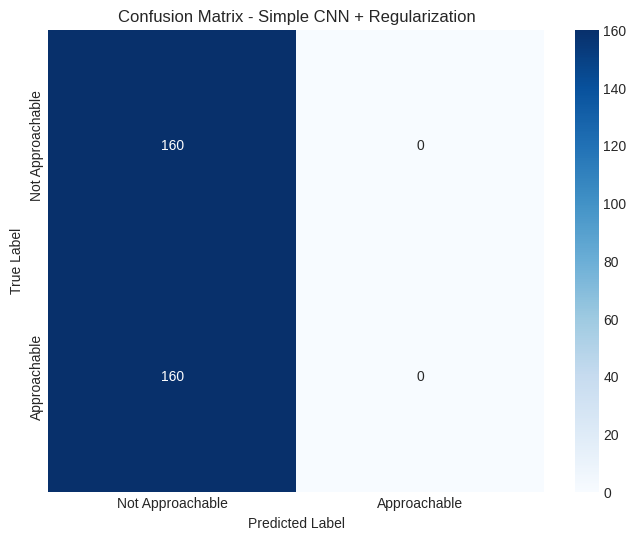

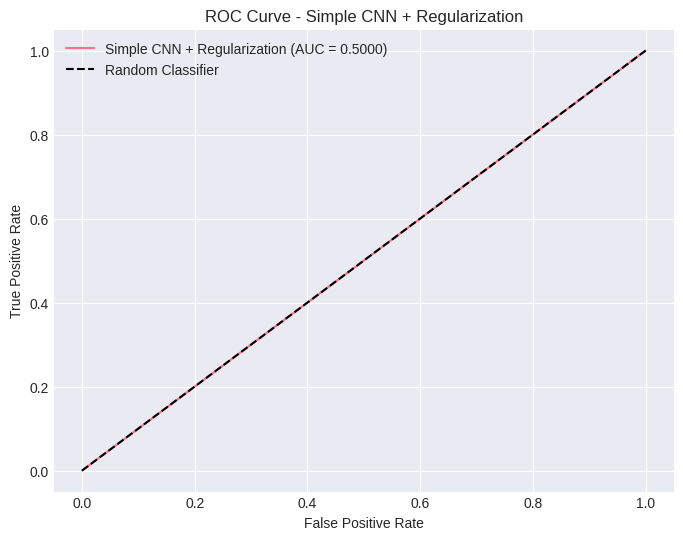


Metrics:
                         Model  Train Error  Validation Error  AUC  Precision  \
0  Simple CNN + Regularization          0.5               0.5  0.5        0.0   

   Recall  
0     0.0  


15083

In [37]:
# Experiment 5: Simple CNN with Dropout/Regularization
print("Experiment 5: Simple CNN with Dropout/Regularization")

model5 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),
                  kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model5.summary())

history5 = model5.fit(
    X_train_img, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_img, y_val),
    verbose=1
)

# Evaluate (Simple CNN uses [0,1] images: X_train_img, X_val_img)
metrics_df_dl5 = evaluate_dl_model(model5, history5, X_train_img, X_val_img,
                                    y_train, y_val, "Simple CNN + Regularization")
dl_results.append(metrics_df_dl5)
dl_models.append(model5)
print("\nMetrics:")
print(metrics_df_dl5)

# Keep model in dl_models for final test evaluation
import gc
gc.collect()

### Deep Learning Results Summary & Best Model Selection

Compare all 5 deep learning experiments to identify the best performing model.

DEEP LEARNING EXPERIMENTS SUMMARY
                          Model  Train Error  Validation Error      AUC  Precision  Recall
        EfficientNetB0 (Frozen)     0.004167          0.065625 0.978730   0.906433 0.96875
    EfficientNetB0 (Fine-tuned)     0.001042          0.012500 0.999141   1.000000 0.97500
  EfficientNetB0 + Augmentation     0.040625          0.081250 0.979492   0.946667 0.88750
EfficientNetB0 (Adam LR=0.0001)     0.042708          0.071875 0.969492   0.947712 0.90625
    Simple CNN + Regularization     0.500000          0.500000 0.500000   0.000000 0.00000

BEST DEEP LEARNING MODEL
Model               EfficientNetB0 (Fine-tuned)
Train Error                            0.001042
Validation Error                         0.0125
AUC                                    0.999141
Precision                                   1.0
Recall                                    0.975
Name: 1, dtype: object


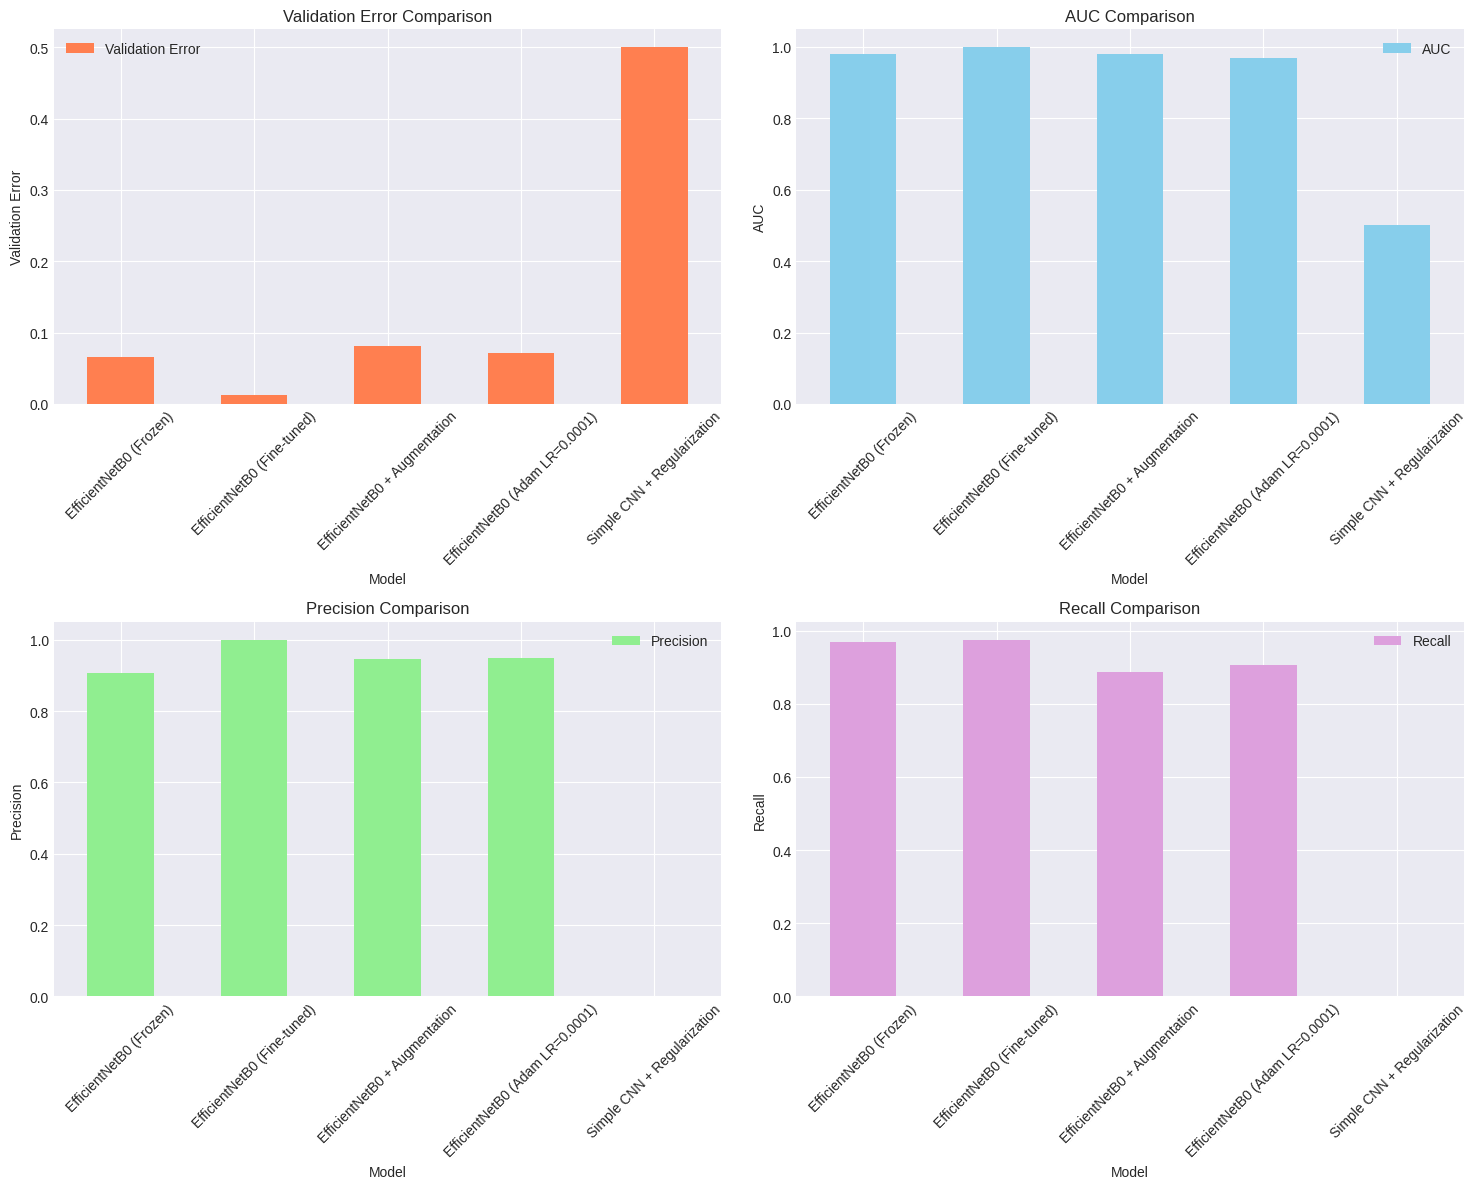

In [38]:
# Combine all DL results
dl_summary = pd.concat(dl_results, ignore_index=True)
print("=" * 80)
print("DEEP LEARNING EXPERIMENTS SUMMARY")
print("=" * 80)
print(dl_summary.to_string(index=False))

# Find best model
best_dl_idx = dl_summary['AUC'].idxmax()
best_dl_model = dl_summary.iloc[best_dl_idx]

print("\n" + "=" * 80)
print("BEST DEEP LEARNING MODEL")
print("=" * 80)
print(best_dl_model)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Validation Error comparison
dl_summary.plot(x='Model', y='Validation Error', kind='bar', ax=axes[0,0], color='coral')
axes[0,0].set_title('Validation Error Comparison')
axes[0,0].set_ylabel('Validation Error')
axes[0,0].tick_params(axis='x', rotation=45)

# AUC comparison
dl_summary.plot(x='Model', y='AUC', kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('AUC Comparison')
axes[0,1].set_ylabel('AUC')
axes[0,1].tick_params(axis='x', rotation=45)

# Precision comparison
dl_summary.plot(x='Model', y='Precision', kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Precision Comparison')
axes[1,0].set_ylabel('Precision')
axes[1,0].tick_params(axis='x', rotation=45)

# Recall comparison
dl_summary.plot(x='Model', y='Recall', kind='bar', ax=axes[1,1], color='plum')
axes[1,1].set_title('Recall Comparison')
axes[1,1].set_ylabel('Recall')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Final Deep Learning Test Set Evaluation

Evaluate the **best** DL model (chosen by validation AUC) on the **held-out test set** once. Experiment 5 (Simple CNN) uses raw images; all others use EfficientNet-preprocessed inputs.

BEST DEEP LEARNING MODEL — TEST SET PERFORMANCE (held-out, no selection on test)
Model: EfficientNetB0 (Fine-tuned)
Test Loss:     0.1057
Test Accuracy: 0.9625
Test F1:       0.9630
Test Precision: 0.9512
Test Recall:   0.9750
Test AUC:      0.9942



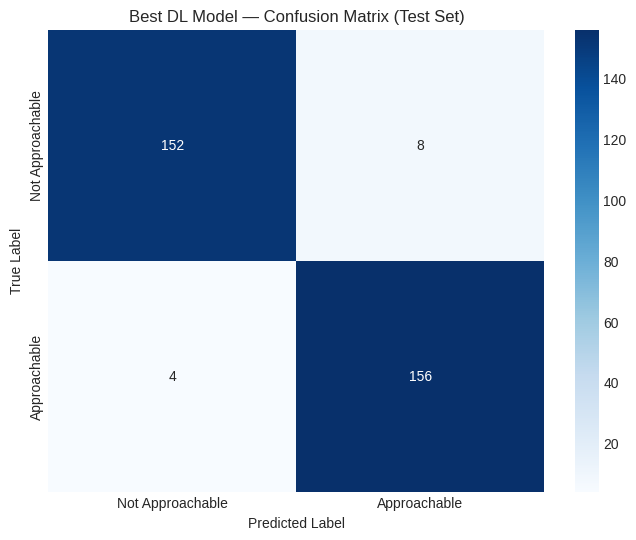

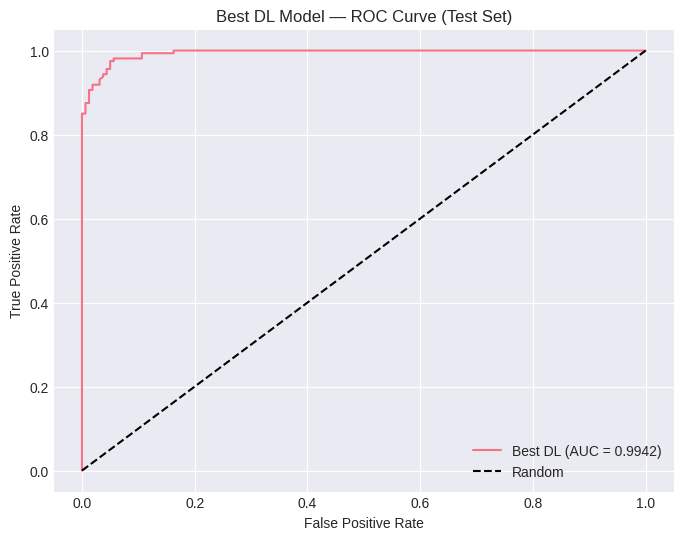

In [39]:
# Best DL model: final evaluation on TEST set
best_dl_actual = dl_models[best_dl_idx]
# Experiment 5 (index 4) is Simple CNN — uses raw [0,1] images; others use EfficientNet-preprocessed
X_test_dl = X_test_img if best_dl_idx == 4 else X_test_eff

test_loss_dl, test_acc_dl = best_dl_actual.evaluate(X_test_dl, y_test, verbose=0)
y_test_proba_dl = best_dl_actual.predict(X_test_dl, verbose=0).ravel()
y_test_pred_dl = (y_test_proba_dl > 0.5).astype(int)

test_f1_dl = f1_score(y_test, y_test_pred_dl, average='binary', zero_division=0)
test_precision_dl = precision_score(y_test, y_test_pred_dl, average='binary', zero_division=0)
test_recall_dl = recall_score(y_test, y_test_pred_dl, average='binary', zero_division=0)
test_auc_dl = roc_auc_score(y_test, y_test_proba_dl)

print("=" * 80)
print("BEST DEEP LEARNING MODEL — TEST SET PERFORMANCE (held-out, no selection on test)")
print("=" * 80)
print(f"Model: {best_dl_model['Model']}")
print(f"Test Loss:     {test_loss_dl:.4f}")
print(f"Test Accuracy: {test_acc_dl:.4f}")
print(f"Test F1:       {test_f1_dl:.4f}")
print(f"Test Precision: {test_precision_dl:.4f}")
print(f"Test Recall:   {test_recall_dl:.4f}")
print(f"Test AUC:      {test_auc_dl:.4f}")
print()

# Confusion matrix on test
cm_test_dl = confusion_matrix(y_test, y_test_pred_dl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approachable', 'Approachable'],
            yticklabels=['Not Approachable', 'Approachable'])
plt.title('Best DL Model — Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve on test
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_test_proba_dl)
plt.figure(figsize=(8, 6))
plt.plot(fpr_dl, tpr_dl, label=f'Best DL (AUC = {test_auc_dl:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best DL Model — ROC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Final Comparison: Best SVM vs Best Deep Learning Model

Compare the best traditional ML model with the best deep learning model to determine the overall best approach for investor mood detection.

FINAL COMPARISON: BEST SVM vs BEST DEEP LEARNING MODEL
                      Model Train Error Validation Error       AUC Precision Recall
               SVM with PCA         0.0         0.009375  0.998633  0.981595    1.0
EfficientNetB0 (Fine-tuned)    0.001042           0.0125  0.999141       1.0  0.975


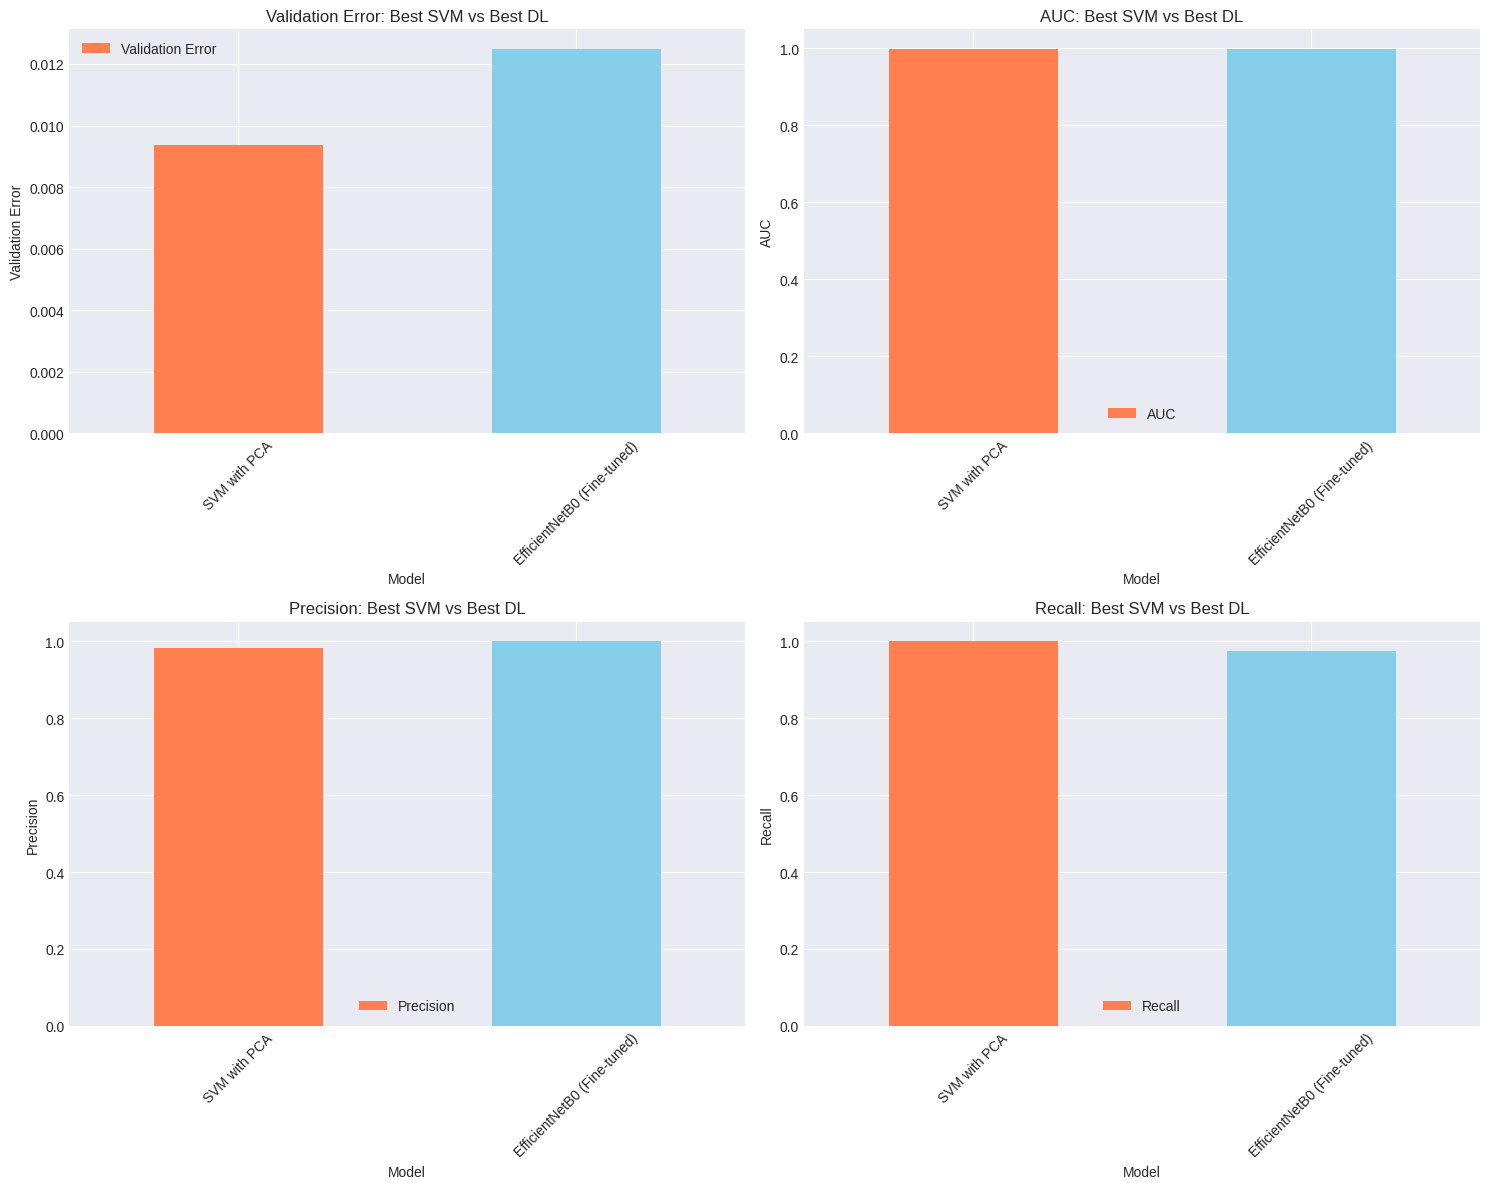


OVERALL BEST MODEL
Model               EfficientNetB0 (Fine-tuned)
Train Error                            0.001042
Validation Error                         0.0125
AUC                                    0.999141
Precision                                   1.0
Recall                                    0.975
Name: 1, dtype: object
Final cleanup done. Results and best models kept.


In [40]:
# Final comparison
final_comparison = pd.concat([
    best_svm_model.to_frame().T,
    best_dl_model.to_frame().T
], ignore_index=True)

print("=" * 80)
print("FINAL COMPARISON: BEST SVM vs BEST DEEP LEARNING MODEL")
print("=" * 80)
print(final_comparison.to_string(index=False))

# Visualize final comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

final_comparison.plot(x='Model', y='Validation Error', kind='bar', ax=axes[0,0], color=['coral', 'skyblue'])
axes[0,0].set_title('Validation Error: Best SVM vs Best DL')
axes[0,0].set_ylabel('Validation Error')
axes[0,0].tick_params(axis='x', rotation=45)

final_comparison.plot(x='Model', y='AUC', kind='bar', ax=axes[0,1], color=['coral', 'skyblue'])
axes[0,1].set_title('AUC: Best SVM vs Best DL')
axes[0,1].set_ylabel('AUC')
axes[0,1].tick_params(axis='x', rotation=45)

final_comparison.plot(x='Model', y='Precision', kind='bar', ax=axes[1,0], color=['coral', 'skyblue'])
axes[1,0].set_title('Precision: Best SVM vs Best DL')
axes[1,0].set_ylabel('Precision')
axes[1,0].tick_params(axis='x', rotation=45)

final_comparison.plot(x='Model', y='Recall', kind='bar', ax=axes[1,1], color=['coral', 'skyblue'])
axes[1,1].set_title('Recall: Best SVM vs Best DL')
axes[1,1].set_ylabel('Recall')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Determine overall best model
overall_best_idx = final_comparison['AUC'].idxmax()
overall_best = final_comparison.iloc[overall_best_idx]

print( "=" * 80)
print("\nOVERALL BEST MODEL")
print( "=" * 80)
print(overall_best)

# Final cleanup: free large intermediates; keep results (final_comparison, svm_summary, dl_results), best models, test set
for _name in ['X_train_img', 'X_val_img', 'X_train_eff', 'X_val_eff', 'train_dataset', 'val_dataset', 'train_ds_eff', 'val_ds_eff']:
    if _name in globals(): exec('del ' + _name)
for _i in range(1, 8):
    _h = 'history' + str(_i)
    if _h in globals(): exec('del ' + _h)
gc.collect()
print("Final cleanup done. Results and best models kept.")

## 6. Conclusions & Insights

### Key Findings

1. **Model Performance Comparison:** [Insert insights from results]
2. **Overfitting/Underfitting Analysis:** [Analyze learning curves]
3. **Error Patterns:** [Analyze confusion matrices]
4. **Feature Importance:** [SHAP insights for SVM models]
5. **Trade-offs:** [Accuracy vs interpretability, computational efficiency]

### Limitations & Future Work

- Dataset limitations
- Model limitations
- Potential improvements
- Real-world deployment considerations